In [2]:
#knitr::purl(here("Rmd/childcare_article_analyses.Rmd"), here("R/childcare_article_analyses.R"))

In [3]:
library(vegan)
library(microbiome)
library(tidyverse)
library(here)

Loading required package: permute
Loading required package: lattice
This is vegan 2.5-3
Loading required package: phyloseq
Loading required package: ggplot2

microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2018 Leo Lahti et al. <microbiome.github.io>


Attaching package: ‘microbiome’

The following object is masked from ‘package:base’:

    transform

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.2     ✔ dplyr   0.7.8
✔ readr   1.1.1     ✔ stringr 1.3.1
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
here() starts at /Users/henrikeckermann/workspace/research_master/minor_research_project/article/analyses/bibo


In [4]:
# load data and helper functions
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/bayesian_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/mb_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/reporting.R")

This is loo version 2.0.0.
**NOTE: As of version 2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. Visit mc-stan.org/loo/news for details on other changes.

Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse



In [5]:
load(here("data/data_transfer.RData"))
source(here("R/read.R"))

Loading required package: DBI
Loading required package: preprocessCore
Loading required package: RMySQL
Loading required package: RPA
Loading required package: affy
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colMeans, colSums, colnames,
    dirname, do.call, duplicated, eval, evalq, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, mapply, match,

In [6]:
# take over the meta variables I created in other docs
meta_new <- data_transfer[, 1:9] 

In [7]:
head(meta_new)

subject_id sample_id time cc  age_d  age_d_s    bf_count bf_count_s  bf_ratio
1 207        sa_10000  post no   98.00  0.0320946 6.00      0.43948544 1       
2 388        sa_10038  post yes  98.00  0.0320946 0.00     -1.65710371 0       
3 381        sa_10118  post yes 108.00  0.5275689 6.59      0.64565004 1       
4 283        sa_10211  post yes 107.03  0.4795079 5.00      0.09005391 1       
5 216        sa_10230  post no  100.00  0.1311895 7.00      0.78891696 1       
6 277        sa_10247  pre  yes  79.00 -0.9093066 6.10      0.47442859 1

In [8]:
# create catories for bf and childcare and specifically for ccyes vs rest
meta_new <- meta_new %>%
  mutate(
      groups = ifelse(time == "pre" & cc == "no", "noCCpre", ifelse(
          time == "pre" & cc == "yes", "CCpre", ifelse(
              time == "post" & cc == "no", "noCCpost", "CCpost"))),
      bf = ifelse(bf_ratio <= 0.25, "lowBF", ifelse(
          bf_ratio <0.75, "mediumBF", "highBF")),
      ccpost = ifelse(groups == "CCpost", 1, 0)) %>% 
  mutate(
      groups = as.factor(groups), 
      bf = as.factor(bf), 
      ccpost = as.factor(ccpost))

In [9]:
# create new pseq object (read.R results in the object "genus" Leo created)
otu <- otu_to_df(genus, transpose = FALSE)
otu <- otu %>% 
    select(species, meta_new$sample_id) %>% 
    df_to_otu()
pseq <- phyloseq(otu, df_to_sd(meta_new), tax_table(genus))
# add diversity indeces to sample data
diversities <- 
    global(pseq, index = "all") %>% 
    select(contains("diversities")) %>% 
    rownames_to_column("sample_id")
colnames(diversities) <- gsub("diversities_", "", colnames(diversities))

sample_data(pseq) <- 
    sd_to_df(pseq) %>% 
    left_join(diversities, by = "sample_id") %>%
    df_to_sd()
meta <- sd_to_df(pseq)
# clr and relative abundance transformation to deal with compositionality of mb data
pseq.clr <- microbiome::transform(pseq, transform = "clr")
pseq.rel <- microbiome::transform(pseq, "compositional")

Richness
Observed (richness 0)
Diversity
Evenness
Dominance
Rarity
Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”Warning message:
“Setting row names on a tibble is deprecated.”Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

# PCA

A PCA using CLR transformed values displays the Aitchison distance.

In [10]:
otus.clr <- otu_to_df(pseq.clr)
colnames(otus.clr)[which(colnames(otus.clr) == "Clostridium \\(sensu stricto\\)")] <- "Clostridium_sensu_stricto"
colnames(otus.clr) <- c("sample_id", gsub("_", "", colnames(otus.clr)[-1]))
colnames(otus.clr) <- gsub("\\.", "", colnames(otus.clr))
colnames(otus.clr) <- gsub(" ", "", colnames(otus.clr))
genus <- colnames(otus.clr)[-1]
data <- sd_to_df(pseq.clr) %>%
    left_join(otus.clr, by = "sample_id")

otus.clr <- otu_to_df(pseq.clr) %>% 
    column_to_rownames("sample_id")
# PCA with CLR values (euclidean distance of clr transformed values = Aitchison distance) 
pcx <- prcomp(otus.clr)
# extract loadings
pcx_rot <- 
    pcx$rotation %>%
        as.tibble() %>%
        mutate_all(function(x) scale(x)[, 1]) %>%
        add_column(genus = rownames(pcx$rotation))

# add PCs to data
princomps <- pcx$x %>% as.data.frame() %>%
    rownames_to_column("sample_id") %>%
    select(PC1, PC2, PC3, sample_id)
data <- data %>% left_join(princomps, by = "sample_id") 
                   
# how much variance do pcs explain?
pc1 <- round(pcx$sdev[1]^2/sum(pcx$sdev^2),2)
pc2 <- round(pcx$sdev[2]^2/sum(pcx$sdev^2),2)
pc3 <- round(pcx$sdev[3]^2/sum(pcx$sdev^2),2)

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

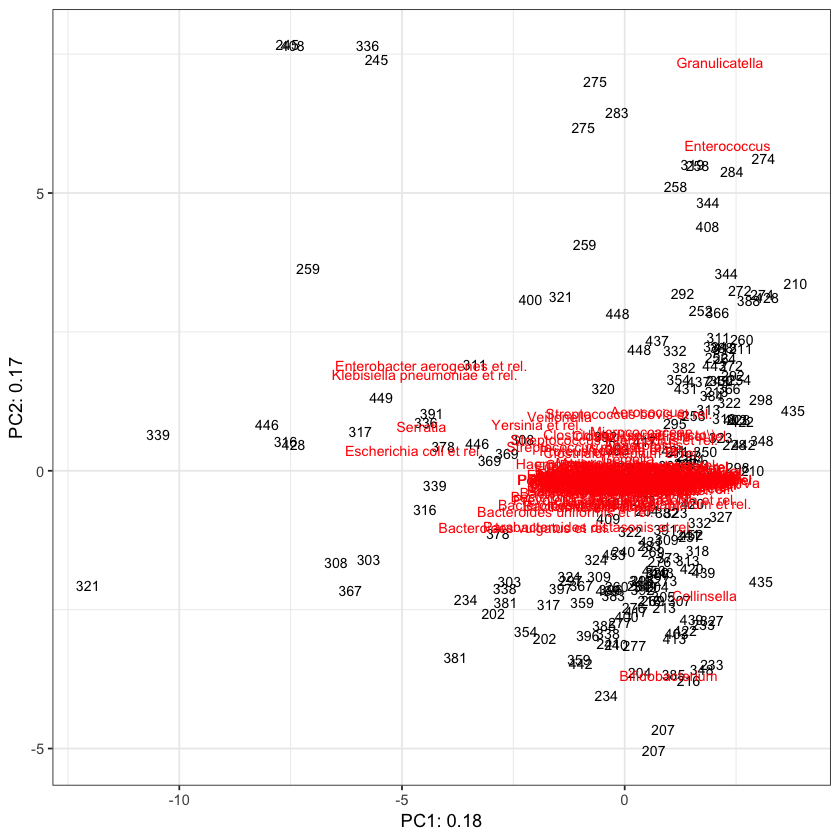

In [11]:
# biplot
data %>%
    ggplot(aes(PC1, PC2, label = subject_id)) +
    geom_text(size = 3) +
    geom_text(data = pcx_rot, aes(PC1, PC2, label = genus), color = "red", size = 3) +
    xlab(paste("PC1: ", pc1, sep="")) +  ylab(paste("PC2: ", pc2, sep="")) +
    theme_bw()

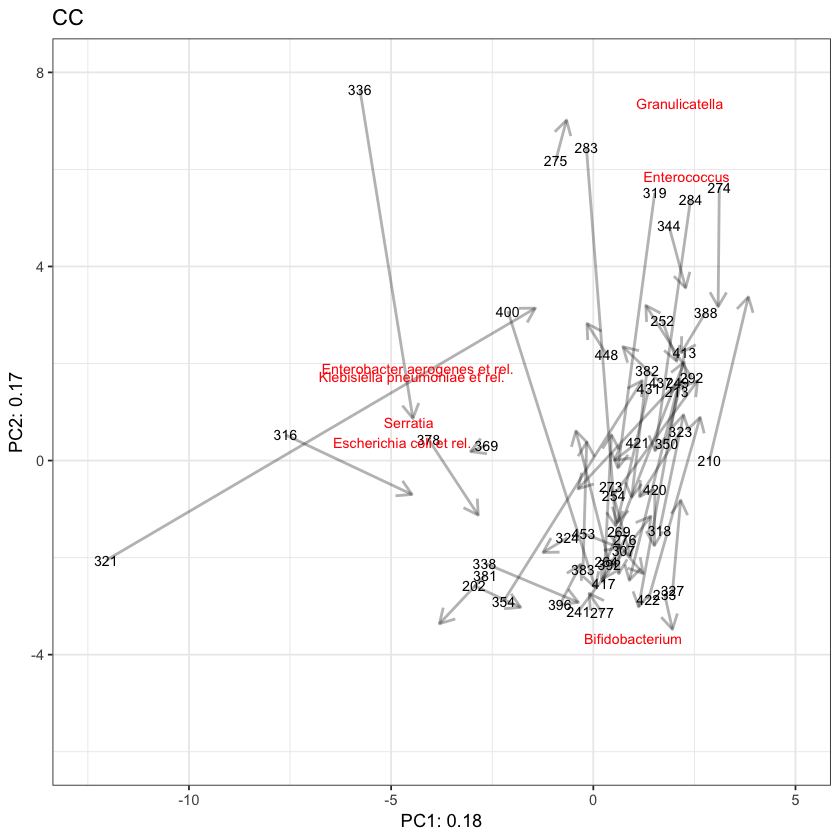

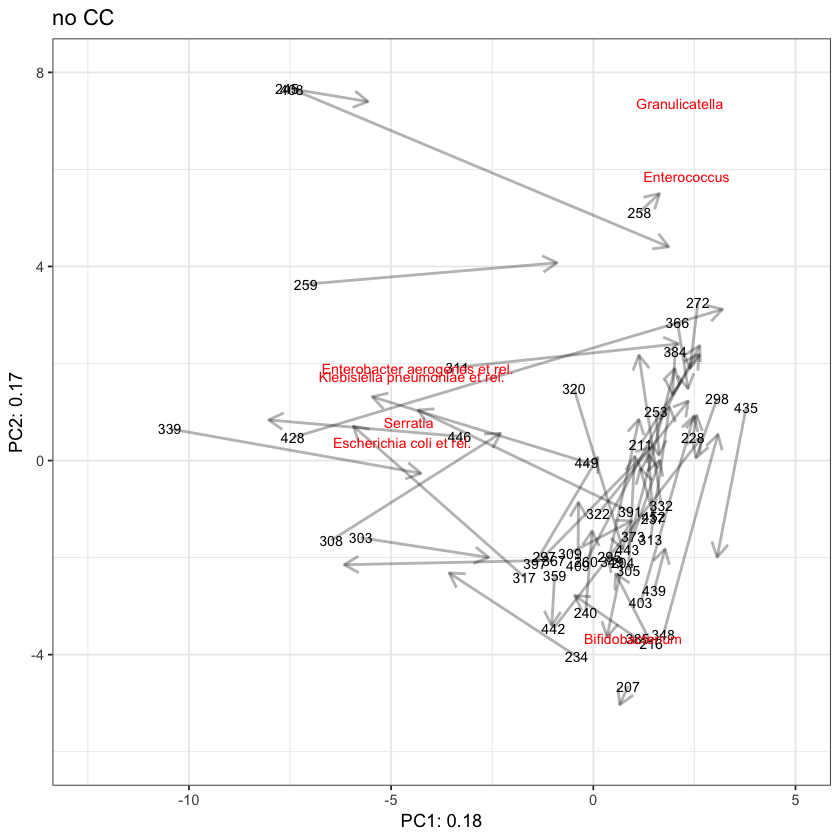

In [12]:
data %>%
    filter(cc == "yes") %>%
    arrange(time) %>%
    ggplot(aes(PC1, PC2, label = subject_id)) +
    geom_path(aes(group = as.factor(subject_id)), arrow = arrow(length = unit(0.35,"cm"), ends = "last"), alpha = 0.3, size = 0.8) +
    scale_color_manual(values = c("red", "blue")) +
    geom_text(size = 3, aes(label = ifelse(time == "pre", subject_id, ""))) +
    geom_text(
        size = 3,
        data = pcx_rot,
        aes(PC1, PC2, label = ifelse(abs(PC1) > 2.5 | abs(PC2) > 2.5, genus, "")), 
            color = "red") +
    xlim(-12.5, 5) + ylim(-6, 8) +
    xlab(paste("PC1: ", pc1, sep="")) +  ylab(paste("PC2: ", pc2, sep="")) +
    ggtitle("CC") +
    theme_bw()
data %>%
    filter(cc == "no") %>%
    arrange(time) %>%
    ggplot(aes(PC1, PC2, label = subject_id)) +
    geom_path(aes(group = as.factor(subject_id)), arrow = arrow(length = unit(0.35,"cm"), ends = "last"), alpha = 0.3, size = 0.8) +
    scale_color_manual(values = c("red", "blue")) +
    geom_text(size = 3, aes(label = ifelse(time == "pre", subject_id, ""))) +
    geom_text(
        size = 3,
        data = pcx_rot,
        aes(PC1, PC2, label = ifelse(abs(PC1) > 2.5 | abs(PC2) > 2.5, genus, "")), 
            color = "red") +
    xlim(-12.5, 5) + ylim(-6, 8) +
    xlab(paste("PC1: ", pc1, sep="")) +  ylab(paste("PC2: ", pc2, sep="")) +
    ggtitle("no CC") +
    theme_bw()

# PERMANOVA
I cannot use Bray Curtis distance for CLR transformed data. Thus I do it once with relative abundance and for clr transformed data I use Euclidean distance, which then is the Aitchison distance. I

In [13]:
# how many NA? --> 4 CC and 1 no CC
# sd_to_df(pseq.rel) %>% filter(is.na(bf_count_s))
# complete cases for meta data and otus:
meta.rel <- sd_to_df(pseq.rel) %>% na.omit()
otus.rel <- otu_to_df(pseq.rel, transpose = F) %>% 
    column_to_rownames("species") %>%
    select(meta.rel$sample_id) %>%
    t() 

# Homogeneity assumption 
dist <- vegdist(otus.rel)
anova(betadisper(dist, meta.rel$cc))
anova(betadisper(dist, meta.rel$time))
anova(betadisper(dist, meta.rel$groups))
pm <- adonis(otus.rel ~ time * cc + age_d_s + bf_count_s, method = "bray", data = meta)

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

Df  Sum Sq     Mean Sq    F value   Pr(>F)   
Groups      1 0.01068247 0.01068247 0.2699711 0.6039757
Residuals 184 7.28068743 0.03956895        NA        NA

Df  Sum Sq     Mean Sq    F value  Pr(>F)   
Groups      1 0.04615272 0.04615272 1.165477 0.2817456
Residuals 184 7.28637252 0.03959985       NA        NA

Df  Sum Sq    Mean Sq    F value  Pr(>F)   
Groups      3 0.1296022 0.04320073 1.106877 0.3476833
Residuals 182 7.1033489 0.03902939       NA        NA

In [14]:
pm$aov.tab

Df  SumsOfSqs   MeanSqs    F.Model   R2          Pr(>F)
time         1  0.12804862 0.12804862 1.0703925 0.005701048 0.360 
cc           1  0.09689544 0.09689544 0.8099748 0.004314029 0.524 
age_d_s      1  0.26246077 0.26246077 2.1939794 0.011685416 0.044 
bf_count_s   1  0.30644665 0.30644665 2.5616691 0.013643778 0.042 
time:cc      1  0.13369947 0.13369947 1.1176294 0.005952638 0.308 
Residuals  180 21.53299024 0.11962772        NA 0.958703090    NA 
Total      185 22.46054118         NA        NA 1.000000000    NA

Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


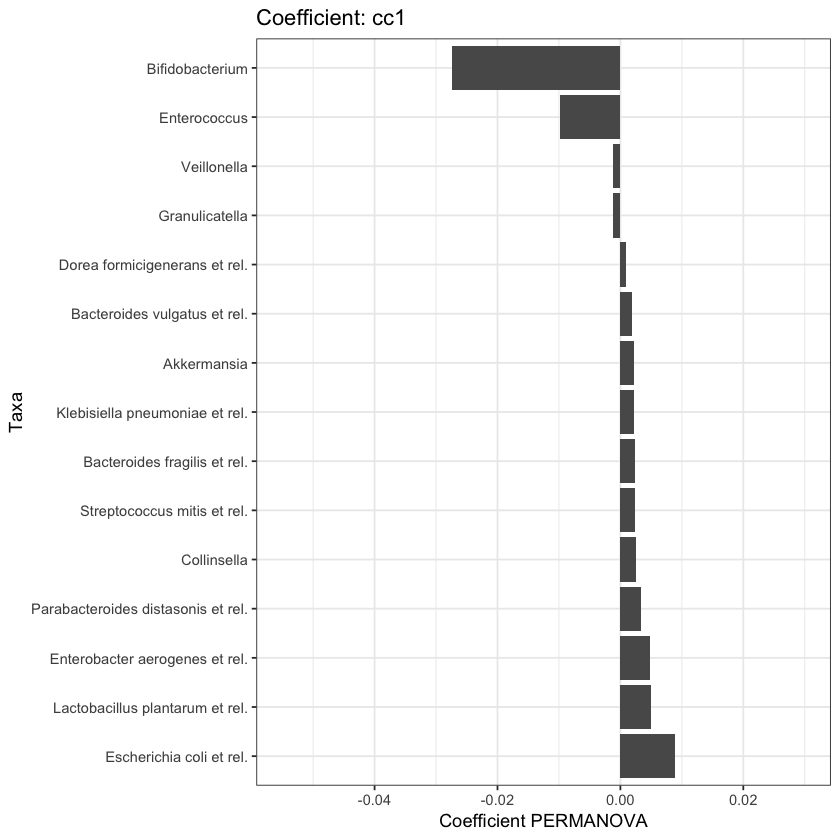

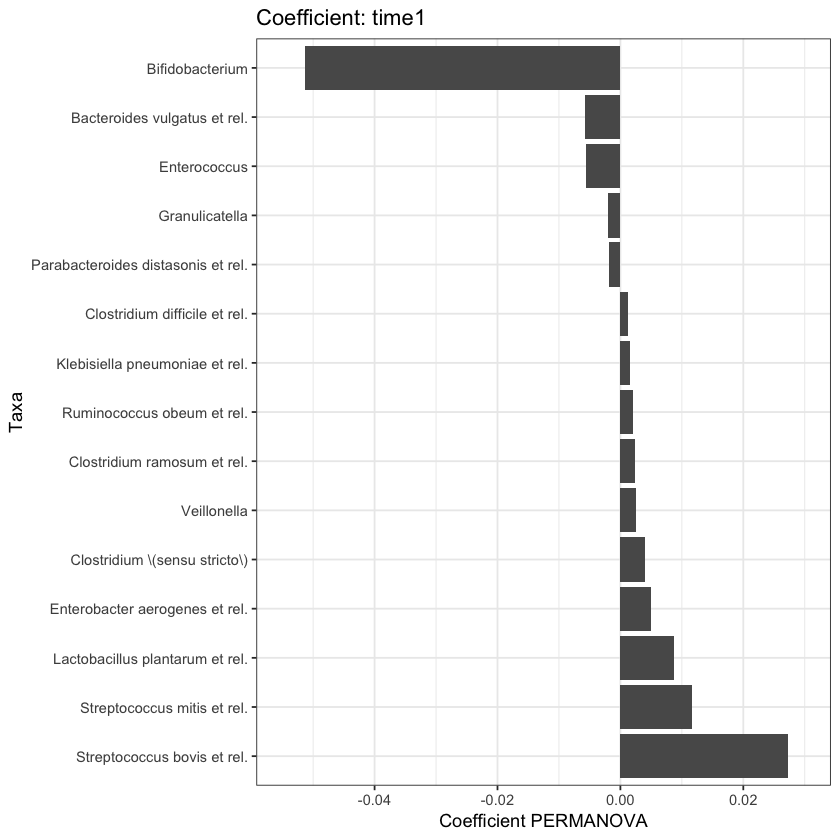

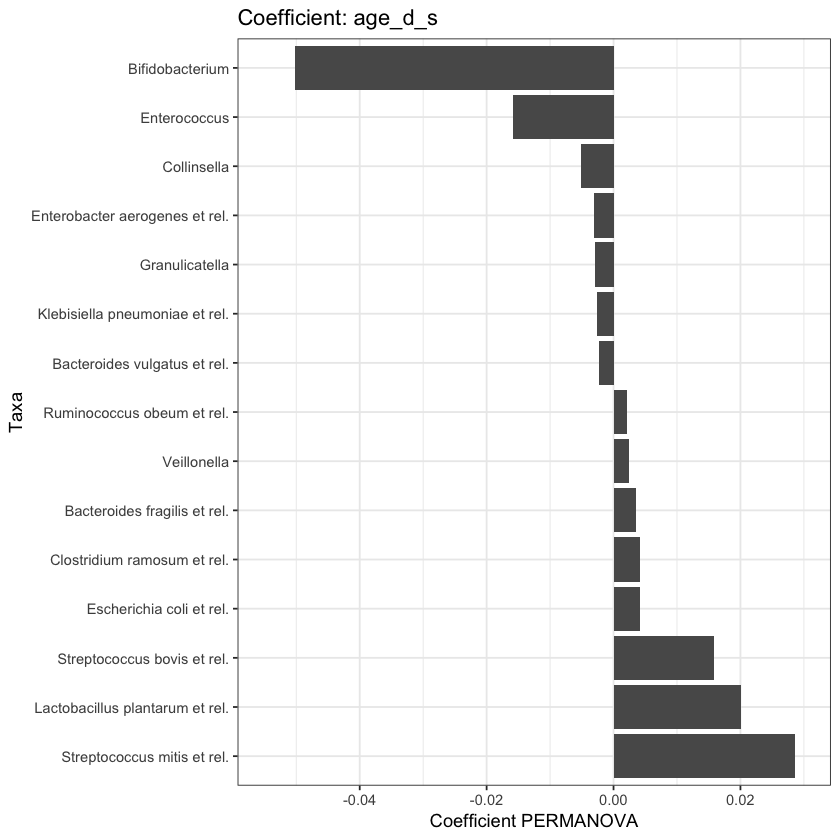

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]


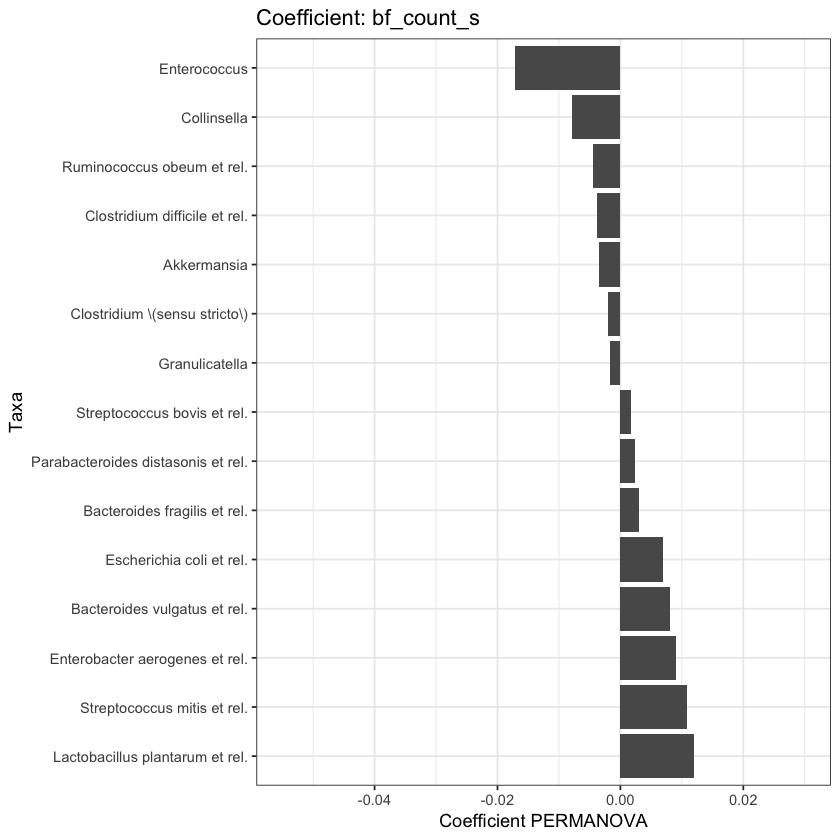

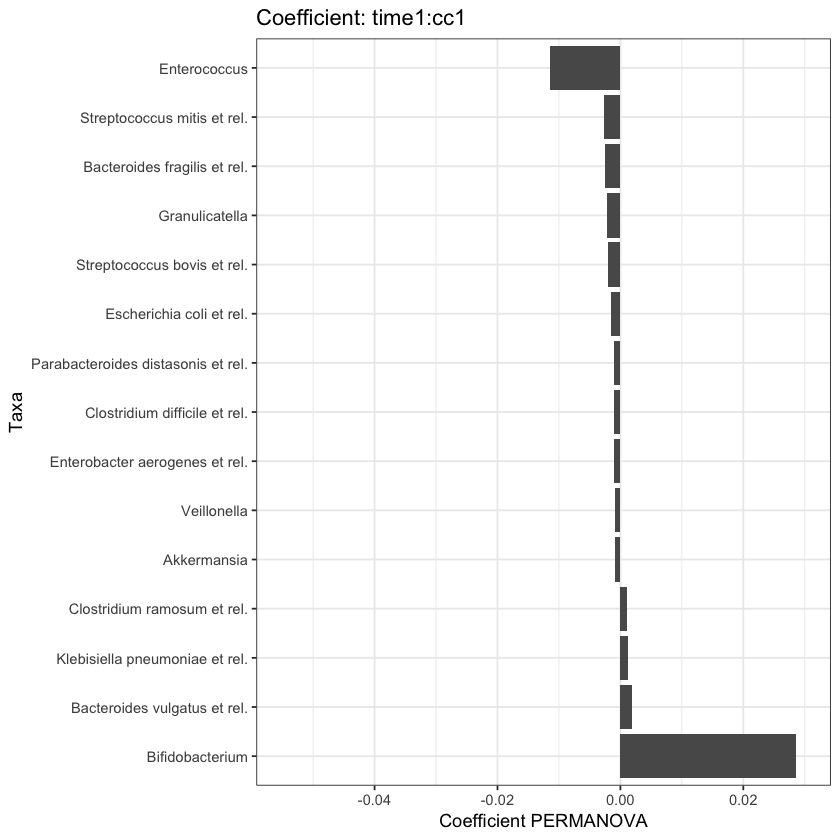

In [15]:
coef_v <- c("cc1", "time1", "age_d_s", "bf_count_s", "time1:cc1")
pmps <- lapply(coef_v, function(x) {
    coef <- coefficients(pm)[x,] 
    # make plot that I can manipulate better for apa6th in case
    coef_top <- 
        coef[rev(order(abs(coef)))[1:15]] %>%
        as.data.frame() %>%
        rownames_to_column("top_taxa") 
    colnames(coef_top) <- c("top_taxa", "coef_top")

    coef_top <- coef_top %>% arrange(desc(coef_top)) %>%
                mutate(top_taxa = factor(top_taxa, levels = top_taxa))
     p <- ggplot(coef_top, aes(top_taxa, coef_top)) +
            geom_bar(stat="identity") +
            ylim(-0.055, 0.03) +
            xlab("Taxa") + ylab("Coefficient PERMANOVA") +
            ggtitle(glue::glue("Coefficient: {x}")) +
            coord_flip() +
            theme_bw()
    ggsave(here(glue("fig/permanova_{x}_rel_ab.png")))
    p
})
pmps

In [16]:
# clr/euclidean
meta.clr <- sd_to_df(pseq.clr) %>% na.omit()
otus.clr <- otu_to_df(pseq.clr, transpose = F) %>% 
    column_to_rownames("species") %>%
    select(meta.clr$sample_id) %>%
    t() 

# Homogeneity assumption 
dist <- vegdist(otus.clr, method = "euclidean")
anova(betadisper(dist, meta.clr$cc))
anova(betadisper(dist, meta.clr$time))
anova(betadisper(dist, meta.clr$groups))
pm <- adonis(otus.clr ~ time * cc + age_d_s + bf_count_s, method = "euclidean", data = meta.clr)

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

Df  Sum Sq     Mean Sq   F value  Pr(>F)   
Groups      1   12.70195 12.701948 2.183615 0.1411961
Residuals 184 1070.31593  5.816934       NA        NA

Df  Sum Sq     Mean Sq  F value  Pr(>F)   
Groups      1   11.29963 11.29963 1.925839 0.1668927
Residuals 184 1079.59786  5.86738       NA        NA

Df  Sum Sq     Mean Sq  F value  Pr(>F)   
Groups      3   26.14298 8.714326 1.465732 0.2254243
Residuals 182 1082.05812 5.945374       NA        NA

In [17]:
pm$aov.tab

Df  SumsOfSqs  MeanSqs   F.Model   R2          Pr(>F)
time         1   54.24038  54.24038 1.3570879 0.007132594 0.185 
cc           1   46.46195  46.46195 1.1624724 0.006109732 0.294 
age_d_s      1   65.49928  65.49928 1.6387841 0.008613135 0.083 
bf_count_s   1  208.93920 208.93920 5.2276341 0.027475443 0.001 
time:cc      1   35.16046  35.16046 0.8797105 0.004623590 0.512 
Residuals  180 7194.27865  39.96821        NA 0.946045506    NA 
Total      185 7604.57991        NA        NA 1.000000000    NA

Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


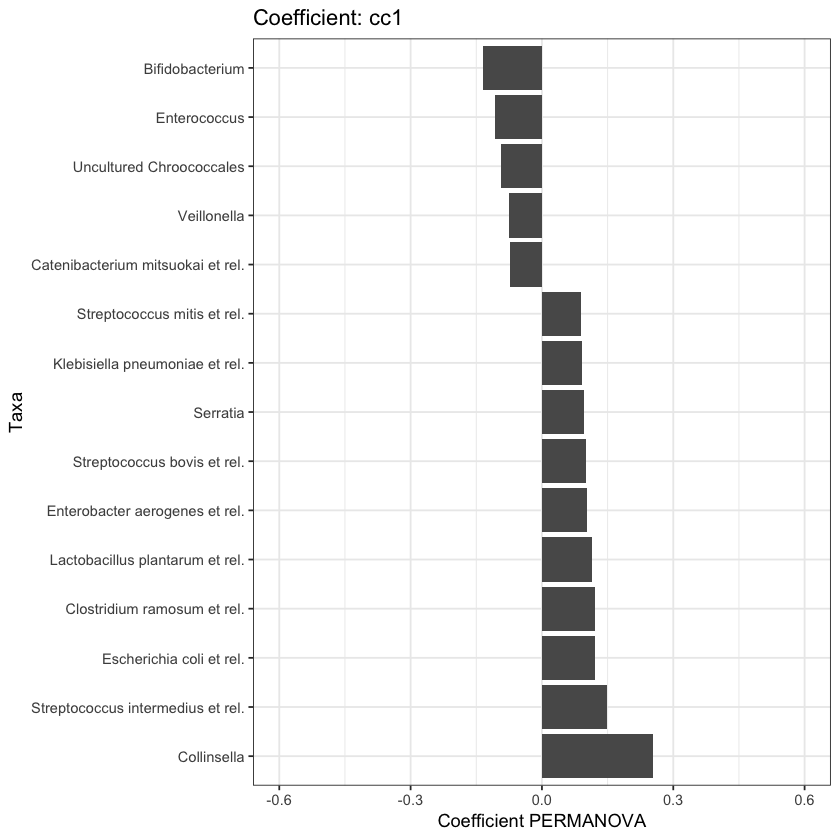

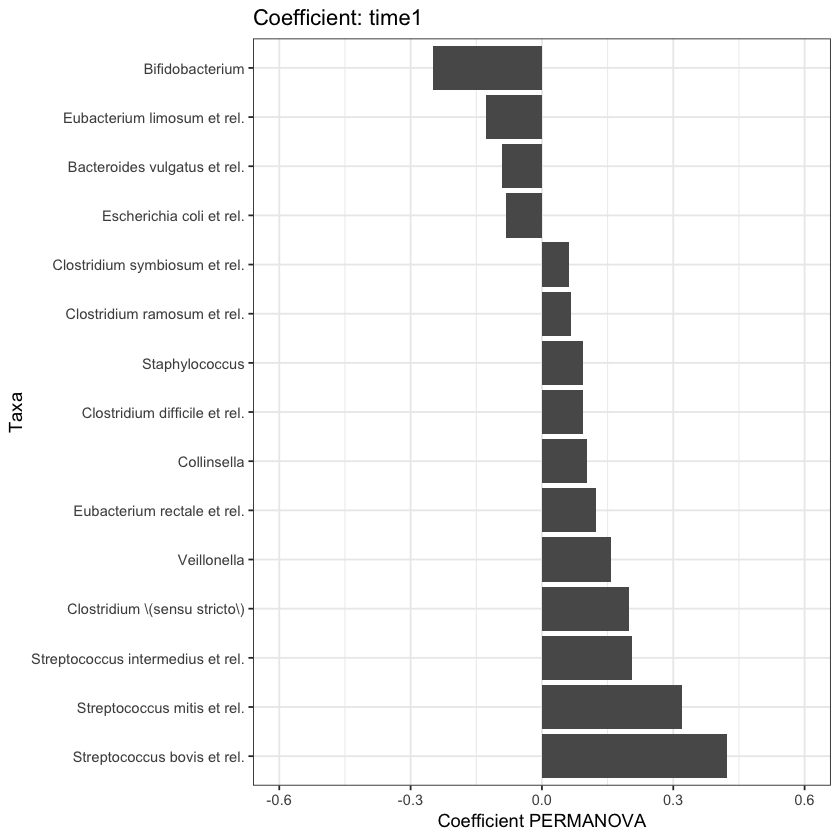

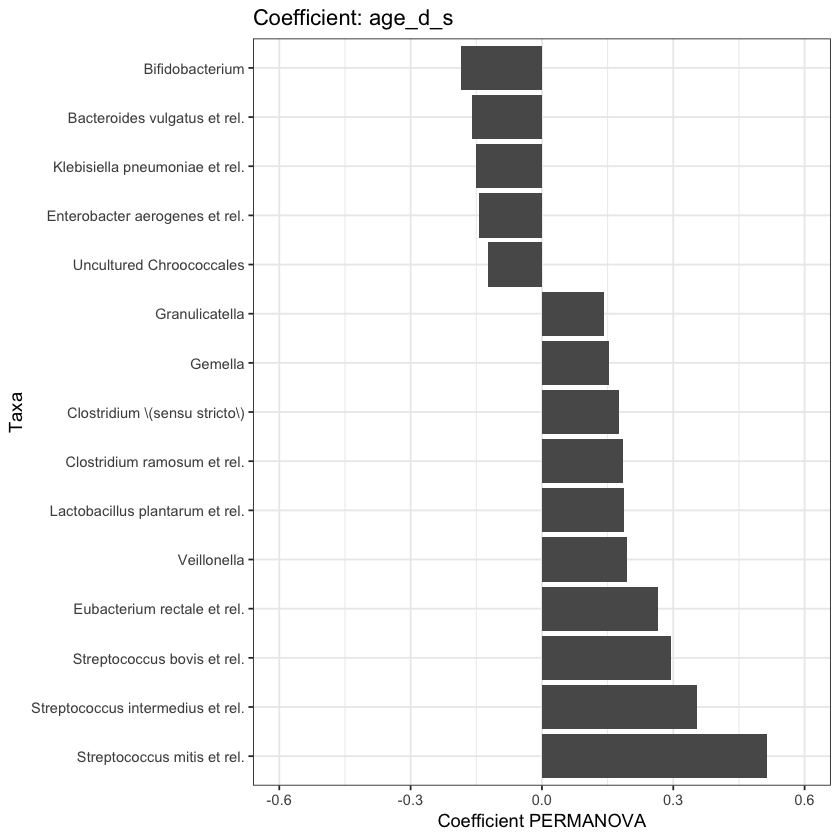

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]


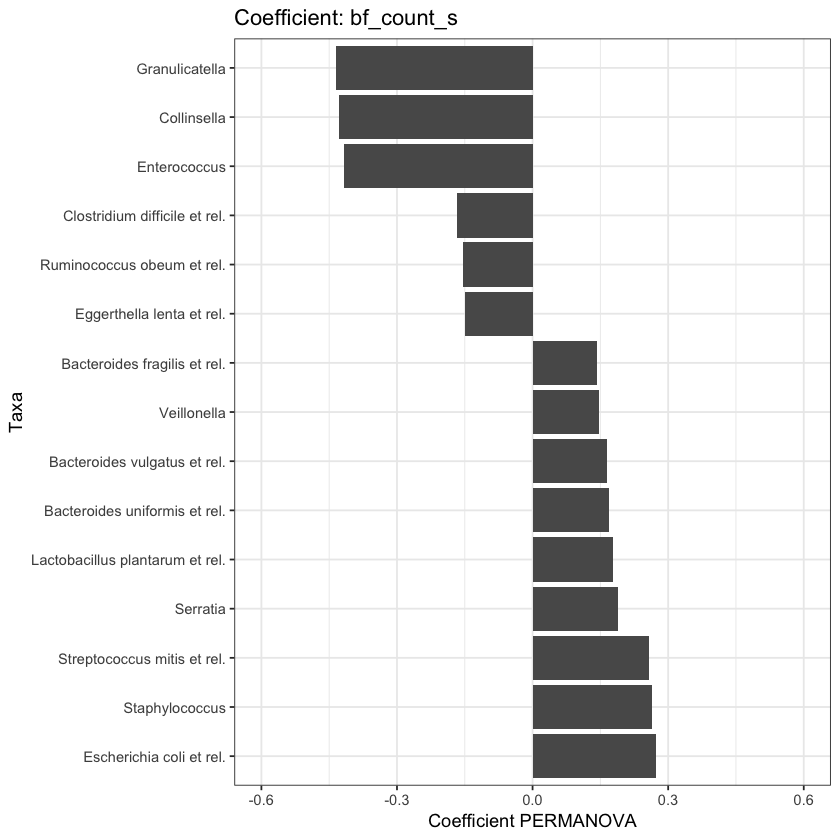

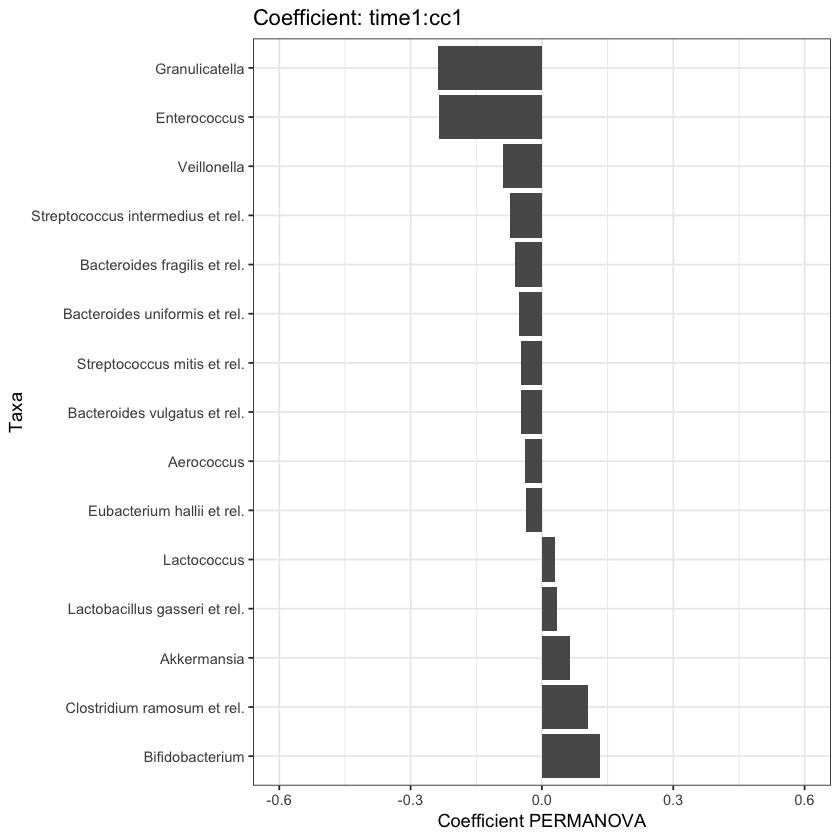

In [18]:
coef_v <- c("cc1", "time1", "age_d_s", "bf_count_s", "time1:cc1")
pmps <- lapply(coef_v, function(x) {
    coef <- coefficients(pm)[x,] 
    # make plot that I can manipulate better for apa6th in case
    coef_top <- 
        coef[rev(order(abs(coef)))[1:15]] %>%
        as.data.frame() %>%
        rownames_to_column("top_taxa") 
    colnames(coef_top) <- c("top_taxa", "coef_top")

    coef_top <- coef_top %>% arrange(desc(coef_top)) %>%
                mutate(top_taxa = factor(top_taxa, levels = top_taxa))
     p <- ggplot(coef_top, aes(top_taxa, coef_top)) +
            geom_bar(stat="identity") +
            ylim(-0.6, 0.6) +
            xlab("Taxa") + ylab("Coefficient PERMANOVA") +
            ggtitle(glue::glue("Coefficient: {x}")) +
            coord_flip() +
            theme_bw()
    ggsave(here(glue("fig/permanova_{x}_clr.png")))
    p
})
pmps

In [19]:
### make tables for permanovs apa
pm_table <- rownames_to_column(pm$aov.tab, "Model Parameters")
pm_table <- 
  mutate_if(pm_table, is.numeric, funs(round(., 3))) %>%
    mutate(
      MeanSqs = ifelse(is.na(MeanSqs), "-", MeanSqs),
      F.Model = ifelse(is.na(F.Model), "-", F.Model),
      `Pr(>F)` = ifelse(is.na(`Pr(>F)`), "-", `Pr(>F)`)) %>%
    select(`Model Parameters`,SumsOfSqs, MeanSqs, F.Model, Df,`Pr(>F)`, R2)
colnames(pm_table) <- c("Model Parameter", "Sum of Squares", "Mean Sum of Squares", "F", "Df", "p", "R Square" )

In [20]:
pm_table

Model Parameter Sum of Squares Mean Sum of Squares F     Df  p     R Square
1 time              54.240       54.24               1.357   1 0.185 0.007   
2 cc                46.462       46.462              1.162   1 0.294 0.006   
3 age_d_s           65.499       65.499              1.639   1 0.083 0.009   
4 bf_count_s       208.939       208.939             5.228   1 0.001 0.027   
5 time:cc           35.160       35.16               0.88    1 0.512 0.005   
6 Residuals       7194.279       39.968              -     180 -     0.946   
7 Total           7604.580       -                   -     185 -     1.000

# Principal Coordinate Analysis

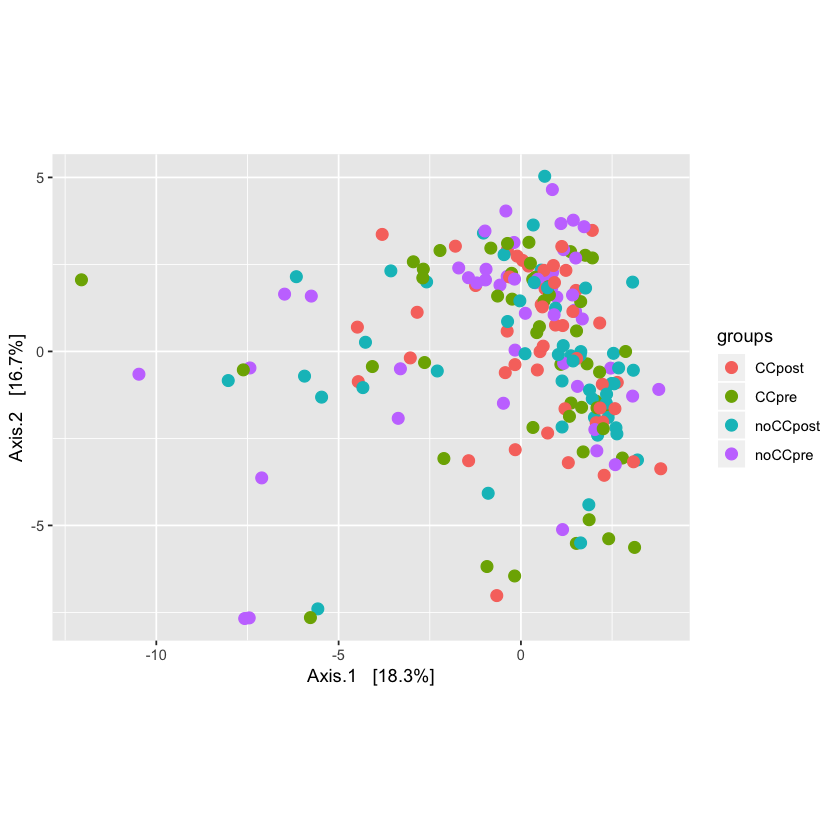

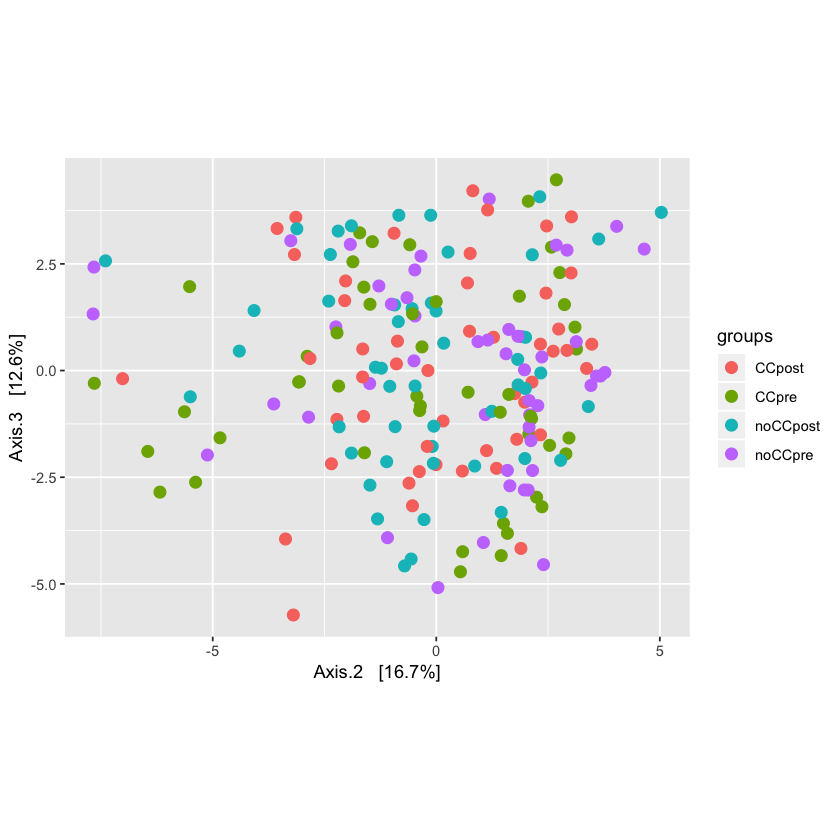

In [21]:
# # PCoA bray, can we differentiate the post CC from all other infants?
# cc_pcoa <- ordinate(pseq.rel, method = "PCoA", distance = "bray")
# e_values <- cc_pcoa$values$Eigenvalues
# plot_ordination(pseq.rel, cc_pcoa, color = "groups") +
#     geom_point(size = 3) +
#     coord_fixed(sqrt(e_values[2] / e_values[1])) 
# # axes 2:3
# plot_ordination(pseq.rel, cc_pcoa, color = "groups", axes = 2:3) +
#     geom_point(size = 3) +
#     coord_fixed(sqrt(e_values[2] / e_values[1])) 


# PCoA Aitchison, can we differentiate the post CC from all other infants?
cc_pcoa <- ordinate(pseq.clr, method = "PCoA", distance = "euclidean")
e_values <- cc_pcoa$values$Eigenvalues
plot_ordination(pseq.clr, cc_pcoa, color = "groups") +
    geom_point(size = 3) +
    coord_fixed(sqrt(e_values[2] / e_values[1])) 
# axes 2:3
plot_ordination(pseq.clr, cc_pcoa, color = "groups", axes = 2:3) +
    geom_point(size = 3) +
    coord_fixed(sqrt(e_values[2] / e_values[1]))

# Hierarchical Generalized Linear Models

In [22]:
future::availableCores()

system 
     8

In [23]:
library(brms)
library(broom)
library(parallel)
options(mc.cores = 6)

Loading required package: Rcpp
Loading 'brms' package (version 2.6.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.

Attaching package: ‘brms’

The following object is masked from ‘package:affy’:

    mm

The following object is masked from ‘package:phyloseq’:

    nsamples



## Alpha diversity regressed on X

I started with a prior of exp(10). From my limited experience, models will converge if I use a strong prior here. The prior assigns low probability to high variation of the distribution of the intercepts and slopes per individual.

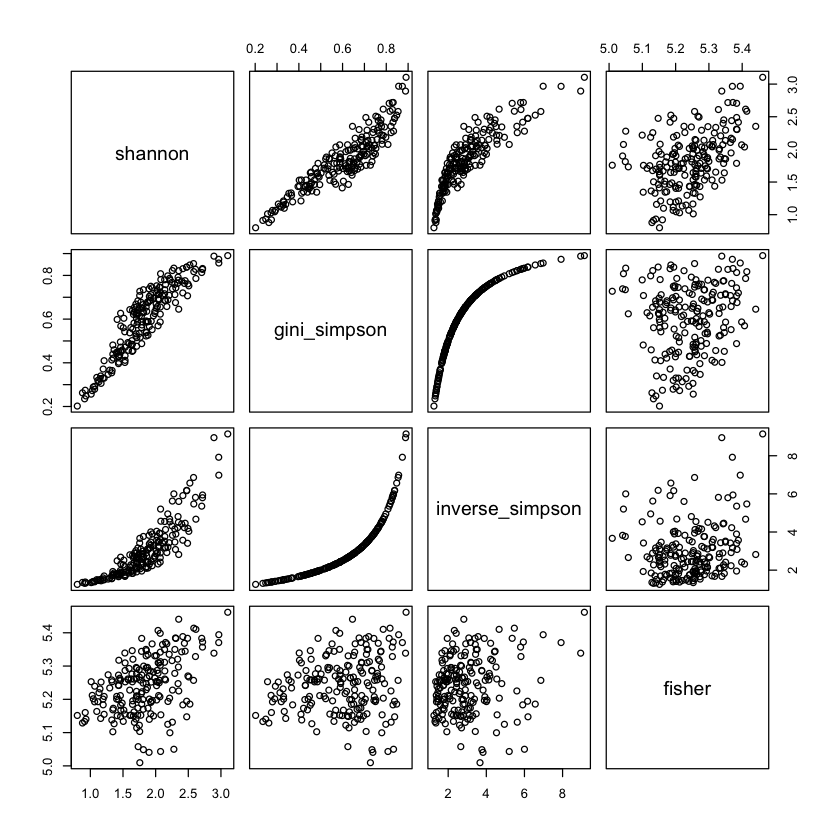

shannon   gini_simpson inverse_simpson fisher   
shannon         1.0000000 0.9164824    0.8751893       0.4663433
gini_simpson    0.9164824 1.0000000    0.8733145       0.1690166
inverse_simpson 0.8751893 0.8733145    1.0000000       0.1793253
fisher          0.4663433 0.1690166    0.1793253       1.0000000

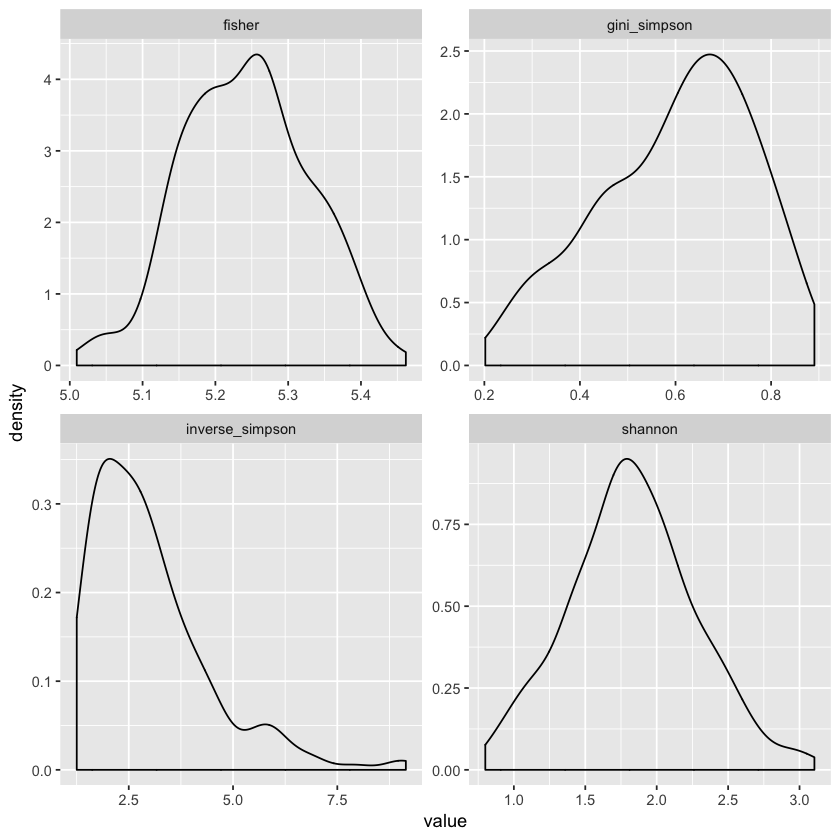

In [24]:
data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    pairs()

data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    gather(index, value) %>%
    ggplot(aes(value)) +
    geom_density() +
    facet_wrap(~index, scales = "free")

data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    cor()

In [25]:
dir.create(here("models/final_analyses"))
folder <- here("models/final_analyses")
diversity_index <- c("shannon", "inverse_simpson", "gini_simpson", "fisher")

Warning message in dir.create(here("models/final_analyses")):
“'/Users/henrikeckermann/workspace/research_master/minor_research_project/article/analyses/bibo/models/final_analyses' already exists”

### Model specification
I will define different models using either gaussian or skew_normal distribution and also using either the integrated missing value treatment from BRMS or not. The rationale behind using it is that I will have more power to evaluate the hypotheses whether CC has effect on MB. Breastfeeding is a covariate and the uncertainty introduced imputation will be reflected in the posterior. 

The skew_normal should better be able to deal with the inverse simpson but in the end both should be fine.

In [26]:
# # create directories
# lapply(diversity_index, function(x) {
#     dir.create(glue("{folder}/{x}"))
#     dir.create(glue("{folder}/{x}/gaussian"))
#     dir.create(glue("{folder}/{x}/skew_normal"))
# })

In [27]:
prior <- 
    c(
        set_prior("normal(0, 2)", class = "b"),
        set_prior("exponential(20)", class = "sd"),
        set_prior("normal(0, 10)", class = "Intercept"),
        set_prior("lkj(2)", class = "cor")
    )

brm_div <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/gaussian/full")
        #fit model
        brm(
            family = gaussian(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15),
            prior = prior, file = model_file
        )
}


brm_div_mi <- function(diversity_index) {
        # delete _ for prior
        div_prior <- gsub("_", "", diversity_index)
        # specify prior for mi version
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = div_prior),
            set_prior("exponential(15)", class = "sd", resp = div_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = div_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
        )
        # formula
        f1 <- as.formula(glue("{diversity_index} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
        f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {diversity_index} + age_d_s + (1 + time + age_d_s + {diversity_index}|subject_id)"))
        formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
        model_file <- glue("{folder}/{diversity_index}/gaussian/full_mi")
        #fit model
        brm(
            family = gaussian(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15), 
            prior = prior_n, file = model_file
        )
}

brm_div_skew <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/skew_normal/full")
        #fit model
        brm(
            family = skew_normal(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999), 
            prior = prior, file = model_file
        )
}


brm_div_skew_mi <- function(diversity_index) {
        # delete _ for prior
        div_prior <- gsub("_", "", diversity_index)
        # specify prior 
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = div_prior),
            set_prior("exponential(15)", class = "sd", resp = div_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = div_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts"))
        # formula
        f1 <- as.formula(glue("{diversity_index} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
        f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {diversity_index} + age_d_s + (1 + time + age_d_s + {diversity_index}|subject_id)"))
        formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
        model_file <- glue("{folder}/{diversity_index}/skew_normal/full_mi")
        #fit model
        brm(
            family = skew_normal(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15), 
            prior = prior_n, file = model_file
        )
}

In [28]:
# gaussian family and listwise deletion
div_models <- lapply(diversity_index, brm_div)

In [29]:
# gaussian and mi for bf_count_s missingness
div_models_mi <- lapply(diversity_index, brm_div_mi)

In [30]:
# skew family and listwise deletion
div_models_skew <- lapply(diversity_index, brm_div_skew)

In [31]:
# skew family and mi for bf_count_s missingness
div_models_skew_mi <- lapply(diversity_index, brm_div_skew_mi)

In [32]:
pp_div <- 
    lapply(1:length(div_models), function(x) {
       pp_plot(div_models[[x]], 10,  diversity_index[x])
    } )
pp_div_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models[[x]], 10,  diversity_index[x])
    } )
pp_div_skew <-
    lapply(1:length(div_models_skew), function(x) {
       pp_plot(div_models_skew[[x]], 10,  diversity_index[x])

    } )
pp_div_skew_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models_skew[[x]], 10,  diversity_index[x])
    } )
pp_div_mi <- 
    lapply(1:length(div_models_mi), function(x) {
       pp_plot(div_models_mi[[x]], 10,  diversity_index[x])
    } )
pp_div_mi_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models_mi[[x]], 10,  diversity_index[x])
    } )
pp_div_skew_mi <-
    lapply(1:length(div_models_skew_mi), function(x) {
       pp_plot(div_models_skew_mi[[x]], 10,  diversity_index[x])
    } )
pp_div_skew_mi_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models_skew_mi[[x]], 10,  diversity_index[x])
    } )

In [33]:
lapply(div_models_mi, function(x) {
    tidy(x)[1:13,]
})

[[1]]
                               term    estimate  std.error        lower
1               b_shannon_Intercept  1.89372706 0.08760532  1.753445984
2              b_bfcounts_Intercept  0.46234939 0.29386602 -0.015742227
3                   b_shannon_ccyes  0.02370585 0.09160557 -0.125224778
4                b_shannon_timepost -0.03032074 0.11223950 -0.211971957
5                 b_shannon_age_d_s  0.09488080 0.06176213 -0.006307064
6          b_shannon_ccyes:timepost -0.24639353 0.09381100 -0.400108162
7                  b_bfcounts_ccyes -0.03407822 0.19982350 -0.362423937
8               b_bfcounts_timepost -0.43910298 0.24045711 -0.831404010
9                b_bfcounts_shannon -0.13601546 0.12722321 -0.353022236
10               b_bfcounts_age_d_s -0.14331386 0.15061123 -0.392863281
11        b_bfcounts_ccyes:timepost  0.11835183 0.12698171 -0.093159905
12         bsp_shannon_mibf_count_s -0.07295101 0.03820602 -0.133894329
13 sd_subject_id__shannon_Intercept  0.26541893 0.04321883  0.192727029
          upper
1   2.037094811
2   0.943000411
3   0.171806143
4   0.153263707
5   0.196059967
6  -0.093027107
7   0.290132736
8  -0.042495427
9   0.067359881
10  0.097669637
11  0.326718760
12 -0.008321062
13  0.334479016

[[2]]
                                      term    estimate  std.error        lower
1               b_inversesimpson_Intercept  3.22569051 0.26070535  2.800951843
2                     b_bfcounts_Intercept  0.25419873 0.22339483 -0.106420185
3                   b_inversesimpson_ccyes  0.13468297 0.29144216 -0.342019559
4                b_inversesimpson_timepost -0.20417323 0.37400578 -0.816580885
5                 b_inversesimpson_age_d_s  0.32228711 0.17212246  0.041340731
6          b_inversesimpson_ccyes:timepost -0.75851277 0.38619160 -1.384214519
7                         b_bfcounts_ccyes -0.04469366 0.19992652 -0.381508917
8                      b_bfcounts_timepost -0.47929547 0.23013498 -0.863909877
9               b_bfcounts_inverse_simpson -0.01083126 0.03846016 -0.074336714
10                      b_bfcounts_age_d_s -0.12583155 0.14714968 -0.368492877
11               b_bfcounts_ccyes:timepost  0.15063834 0.12698477 -0.062067829
12         bsp_inversesimpson_mibf_count_s -0.13461956 0.11763954 -0.327359186
13 sd_subject_id__inversesimpson_Intercept  0.14195630 0.16876613  0.005596575
         upper
1   3.66170288
2   0.62681201
3   0.61395228
4   0.40479974
5   0.60788740
6  -0.10784776
7   0.28154172
8  -0.10893515
9   0.05152277
10  0.11563695
11  0.35262806
12  0.05923653
13  0.55019319

[[3]]
                                   term     estimate  std.error        lower
1               b_ginisimpson_Intercept  0.632562709 0.03363762  0.577647724
2                  b_bfcounts_Intercept  0.255714710 0.26844599 -0.189677044
3                   b_ginisimpson_ccyes  0.002755617 0.03628283 -0.056300891
4                b_ginisimpson_timepost -0.025604929 0.04377892 -0.096520875
5                 b_ginisimpson_age_d_s  0.044671334 0.02292286  0.006573206
6          b_ginisimpson_ccyes:timepost -0.086298474 0.03776556 -0.149878569
7                      b_bfcounts_ccyes -0.053484388 0.19976960 -0.384633111
8                   b_bfcounts_timepost -0.515652166 0.23456374 -0.891399649
9               b_bfcounts_gini_simpson -0.020617814 0.30809875 -0.529861910
10                   b_bfcounts_age_d_s -0.102261832 0.14850855 -0.352699703
11            b_bfcounts_ccyes:timepost  0.158869057 0.12880710 -0.050693480
12         bsp_ginisimpson_mibf_count_s -0.006784738 0.01416000 -0.030120438
13 sd_subject_id__ginisimpson_Intercept  0.094402430 0.01949762  0.062399541
         upper
1   0.68792285
2   0.70183659
3   0.06334454
4   0.04706110
5   0.08265053
6  -0.02423238
7   0.27393656
8  -0.12668582
9   0.47250104
10  0.14235810
11  0.37128422
12  0.01625591
13  0.12412522

[[4]]
                              term      estimate   std.error       lower
1               b_fisher_Intercept  5.2278223560 0.018066174  5.

In [34]:
lapply(div_models_skew_mi, function(x) {
    tidy(x)[1:13,]
})
#lapply(div_models_skew_mi, plot)

[[1]]
                               term    estimate  std.error        lower
1               b_shannon_Intercept  1.88439961 0.08948574  1.733681580
2              b_bfcounts_Intercept  0.45135456 0.27270598  0.005144036
3                   b_shannon_ccyes  0.04833789 0.09769097 -0.112292605
4                b_shannon_timepost -0.03032499 0.11477478 -0.218164353
5                 b_shannon_age_d_s  0.09938759 0.06182313 -0.002107777
6          b_shannon_ccyes:timepost -0.26439782 0.09542340 -0.423324577
7                  b_bfcounts_ccyes -0.01936861 0.18564966 -0.323159946
8               b_bfcounts_timepost -0.37378396 0.21556695 -0.732124668
9                b_bfcounts_shannon -0.15262150 0.12165606 -0.357031937
10               b_bfcounts_age_d_s -0.15062888 0.13667574 -0.376072936
11        b_bfcounts_ccyes:timepost  0.09603023 0.12006110 -0.106110687
12         bsp_shannon_mibf_count_s -0.07389353 0.03860975 -0.135863883
13 sd_subject_id__shannon_Intercept  0.28417321 0.04850299  0.209750750
         upper
1   2.03161369
2   0.90418466
3   0.20676035
4   0.15692999
5   0.20223886
6  -0.10367155
7   0.28671921
8  -0.01618459
9   0.04574673
10  0.07560964
11  0.29680609
12 -0.01085610
13  0.35764147

[[2]]
                                      term     estimate  std.error       lower
1               b_inversesimpson_Intercept  3.226386996 0.17351370  2.94757889
2                     b_bfcounts_Intercept  0.202923677 0.21925428 -0.15924557
3                   b_inversesimpson_ccyes -0.114011137 0.17752844 -0.40417514
4                b_inversesimpson_timepost -0.068346923 0.21876420 -0.43471717
5                 b_inversesimpson_age_d_s  0.148743926 0.11209886 -0.02787599
6          b_inversesimpson_ccyes:timepost -0.261933840 0.23317444 -0.65113197
7                         b_bfcounts_ccyes -0.029725745 0.19246100 -0.34968131
8                      b_bfcounts_timepost -0.424796930 0.23122331 -0.80836883
9               b_bfcounts_inverse_simpson -0.005609759 0.03620502 -0.06608942
10                      b_bfcounts_age_d_s -0.120285592 0.14793128 -0.35714836
11               b_bfcounts_ccyes:timepost  0.122243060 0.12321355 -0.08417011
12         bsp_inversesimpson_mibf_count_s -0.054792519 0.06305977 -0.15641730
13 sd_subject_id__inversesimpson_Intercept  0.067325228 0.05888357  0.00455316
         upper
1   3.51501284
2   0.56225791
3   0.18298239
4   0.27486104
5   0.33867752
6   0.11412895
7   0.28461194
8  -0.04877715
9   0.05316490
10  0.12286306
11  0.32292940
12  0.04990787
13  0.18346060

[[3]]
                                   term     estimate  std.error        lower
1               b_ginisimpson_Intercept  0.626203128 0.03059580  0.575732125
2                  b_bfcounts_Intercept  0.201030153 0.26775310 -0.233855789
3                   b_ginisimpson_ccyes  0.015701699 0.03350009 -0.040026203
4                b_ginisimpson_timepost -0.026751817 0.03950818 -0.091274767
5                 b_ginisimpson_age_d_s  0.041533162 0.02064305  0.008825657
6          b_ginisimpson_ccyes:timepost -0.084734768 0.03465564 -0.142713890
7                      b_bfcounts_ccyes -0.039831353 0.19463838 -0.362587079
8                   b_bfcounts_timepost -0.434513718 0.22913305 -0.801177797
9               b_bfcounts_gini_simpson -0.005447869 0.29295612 -0.487518703
10                   b_bfcounts_age_d_s -0.113902207 0.14534421 -0.354815946
11            b_bfcounts_ccyes:timepost  0.127890349 0.12143100 -0.071717118
12         bsp_ginisimpson_mibf_count_s -0.004403476 0.01275915 -0.024702015
13 sd_subject_id__ginisimpson_Intercept  0.084716058 0.01995183  0.052409802
         upper
1   0.67607847
2   0.63824190
3   0.07021493
4   0.03834124
5   0.07732153
6  -0.02789801
7   0.28669738
8  -0.05944830
9   0.47934601
10  0.11934161
11  0.32444190
12  0.01665235
13  0.11572115

[[4]]
                              term     estimate   std.error       lower
1               b_fisher_Intercept  5.227132452 0.017768802  5.19777394
2      

In [35]:
tidy(div_models_skew[[1]]) %>% filter (term == "alpha")

term  estimate  std.error lower     upper   
1 alpha -1.971749 2.543389  -6.510013 1.694973

In [36]:
#posterior_samples(div_models_skew_mi) %>% colnames()

In [37]:
calc_treatment_effect <- function(model, var_name, summarise = TRUE, stat = "mean") {
    var_name <- gsub("_", "", var_name)
    var_name <- gsub("\\.", "", var_name)
    df <- posterior_samples(model) %>%
        select(
            glue("b_{var_name}_Intercept"), 
            glue("b_{var_name}_ccyes"), 
            glue("b_{var_name}_timepost"), 
            glue("b_{var_name}_ccyes:timepost")) %>%
        rename(
            noccpre = glue("b_{var_name}_Intercept"), 
            ccpre = glue("b_{var_name}_ccyes"),
            noccpost = glue("b_{var_name}_timepost"),
            ccpost = glue("b_{var_name}_ccyes:timepost")) %>%
        mutate(
            ccpost = noccpre + ccpre + noccpost + ccpost,
            noccpost = noccpre + noccpost,
            ccpre = noccpre + ccpre
    )    
    if (summarise) {
        df <- df %>% gather(group, value) %>%
            group_by(group) %>%
            do(data.frame(
                central = ifelse(stat == "median", median(.$value), mean(.$value)),
                lower = hpdi(.$value)[1],
                upper = hpdi(.$value)[2]
            ))
    }
    df
}

plot_effects <- function(model, var_name) {
    var_name <- gsub("_", "", var_name)
    var_name <- gsub("\\.", "", var_name)
    df_sum <- calc_treatment_effect(model, var_name)
    df <- calc_treatment_effect(model, var_name, summarise = F)
    # plot
    df %>% gather(group, value) %>%
        ggplot(aes(x = group, value)) +
            geom_jitter(alpha = 0.05, color = "darkred") +
            geom_point(data = df_sum, aes(x = group, y = central), size = 2, color = "red") +
            geom_errorbar(data = df_sum, aes(x = group, y = central,  ymin = lower, ymax = upper), color = "darkred") +
            ggtitle(var_name) +
            theme_bw()
}


In [38]:
lapply(1:length(diversity_index), function(x) {
    var_name <- diversity_index[x]
    var_name <- gsub("_", "", var_name)
    var_name <- gsub("\\.", "", var_name)
    df <- calc_treatment_effect(div_models_mi[[x]], var_name, summarise = F)
    df <- df %>% 
        mutate(            
            ccpost_ccpre = ccpost - ccpre,
            ccpost_noccpre = ccpost - noccpre,
            ccpost_noccpost = ccpost - noccpost,
            ccpre_noccpre = ccpre - noccpre,
            noccpost_noccpre = noccpost - noccpre,
            noccpost_ccpre = noccpost - ccpre
        ) %>%
        select(ccpost_ccpre, ccpost_noccpre, ccpost_noccpost, ccpre_noccpre, noccpost_noccpre, noccpost_ccpre) %>%
        gather(comparison, value) %>%
        group_by(comparison) %>%
        do(data.frame(
            mean_diff = mean(.$value),
            lower = hpdi(.$value)[1],
            upper = hpdi(.$value)[2],
            prob = mean(.$value < 0)
        ))
    df
})


[[1]]
# A tibble: 6 x 5
# Groups:   comparison [6]
  comparison       mean_diff  lower   upper  prob
  <chr>                <dbl>  <dbl>   <dbl> <dbl>
1 ccpost_ccpre       -0.277  -0.499 -0.0444 0.990
2 ccpost_noccpost    -0.223  -0.406 -0.0424 0.990
3 ccpost_noccpre     -0.253  -0.561  0.0400 0.950
4 ccpre_noccpre       0.0237 -0.151  0.208  0.390
5 noccpost_ccpre     -0.0540 -0.240  0.166  0.702
6 noccpost_noccpre   -0.0303 -0.247  0.196  0.604

[[2]]
# A tibble: 6 x 5
# Groups:   comparison [6]
  comparison       mean_diff  lower   upper  prob
  <chr>                <dbl>  <dbl>   <dbl> <dbl>
1 ccpost_ccpre        -0.963 -1.71  -0.210  0.994
2 ccpost_noccpost     -0.624 -1.21  -0.0207 0.979
3 ccpost_noccpre      -0.828 -1.70   0.0706 0.966
4 ccpre_noccpre        0.135 -0.435  0.726  0.322
5 noccpost_ccpre      -0.339 -0.960  0.352  0.843
6 noccpost_noccpre    -0.204 -0.906  0.552  0.711

[[3]]
# A tibble: 6 x 5
# Groups:   comparison [6]
  comparison       mean_diff   lower   upper  prob
  <chr>                <dbl>   <dbl>   <dbl> <dbl>
1 ccpost_ccpre      -0.112   -0.197  -0.0304 0.995
2 ccpost_noccpost   -0.0835  -0.151  -0.0154 0.991
3 ccpost_noccpre    -0.109   -0.213   0.0163 0.970
4 ccpre_noccpre      0.00276 -0.0692  0.0717 0.474
5 noccpost_ccpre    -0.0284  -0.104   0.0491 0.768
6 noccpost_noccpre  -0.0256  -0.113   0.0596 0.720

[[4]]
# A tibble: 6 x 5
# Groups:   comparison [6]
  comparison       mean_diff   lower  upper  prob
  <chr>                <dbl>   <dbl>  <dbl> <dbl>
1 ccpost_ccpre       0.00790 -0.0378 0.0514 0.371
2 ccpost_noccpost   -0.00556 -0.0422 0.0303 0.617
3 ccpost_noccpre     0.0215  -0.0399 0.0835 0.251
4 ccpre_noccpre      0.0135  -0.0222 0.0486 0.234
5 noccpost_ccpre     0.0135  -0.0275 0.0559 0.266
6 noccpost_noccpre   0.0270  -0.0190 0.0704 0.121

In [39]:
data %>% select(groups, shannon, inverse_simpson, gini_simpson, fisher) %>%
    gather(index, value, -groups) %>%
    group_by(groups, index) %>%
    summarise(mean = mean(value), meadian = median(value), sd = sd(value))

groups   index           mean      meadian   sd        
1  CCpost   fisher          5.2522786 5.2528107 0.07784588
2  CCpost   gini_simpson    0.5746876 0.6293380 0.16915477
3  CCpost   inverse_simpson 2.7684013 2.6978756 1.24517668
4  CCpost   shannon         1.7645493 1.8542119 0.44695679
5  CCpre    fisher          5.2368965 5.2276967 0.07783146
6  CCpre    gini_simpson    0.6152299 0.6556872 0.17641426
7  CCpre    inverse_simpson 3.1935644 2.9043359 1.44705569
8  CCpre    shannon         1.8606652 1.9031907 0.49455085
9  noCCpost fisher          5.2587590 5.2534083 0.09206145
10 noCCpost gini_simpson    0.6277778 0.6326045 0.14194491
11 noCCpost inverse_simpson 3.2110094 2.7218627 1.64709775
12 noCCpost shannon         1.9287132 1.8741298 0.43620719
13 noCCpre  fisher          5.2220530 5.2488865 0.09309052
14 noCCpre  gini_simpson    0.5830407 0.5684299 0.15096151
15 noCCpre  inverse_simpson 2.8362804 2.3171205 1.36552083
16 noCCpre  shannon         1.7688315 1.7115858 0.37997983

Warning message:
“Ignoring unknown aesthetics: y”Saving 7 x 7 in image
Warning message:
“Ignoring unknown aesthetics: y”Saving 7 x 7 in image
Warning message:
“Ignoring unknown aesthetics: y”Saving 7 x 7 in image
Warning message:
“Ignoring unknown aesthetics: y”Saving 7 x 7 in image


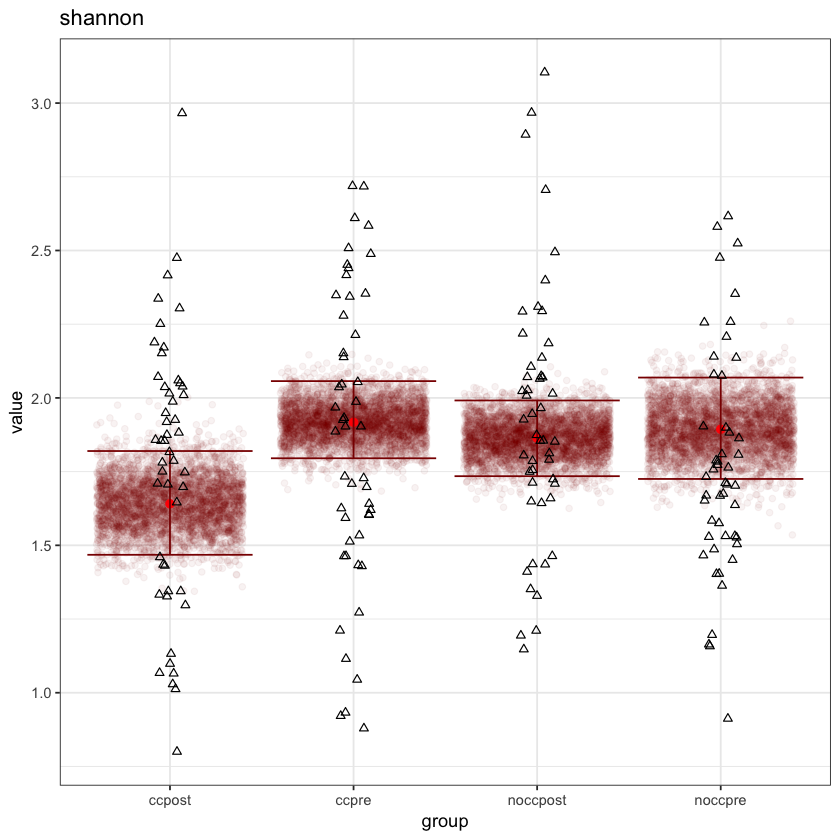

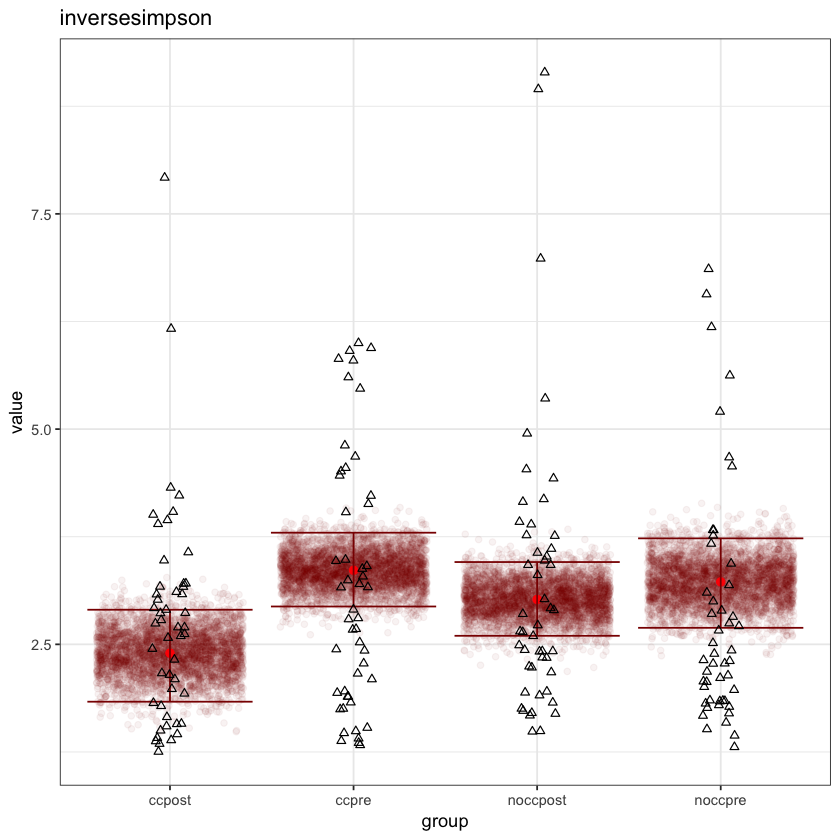

[[1]]

[[2]]

[[3]]

[[4]]


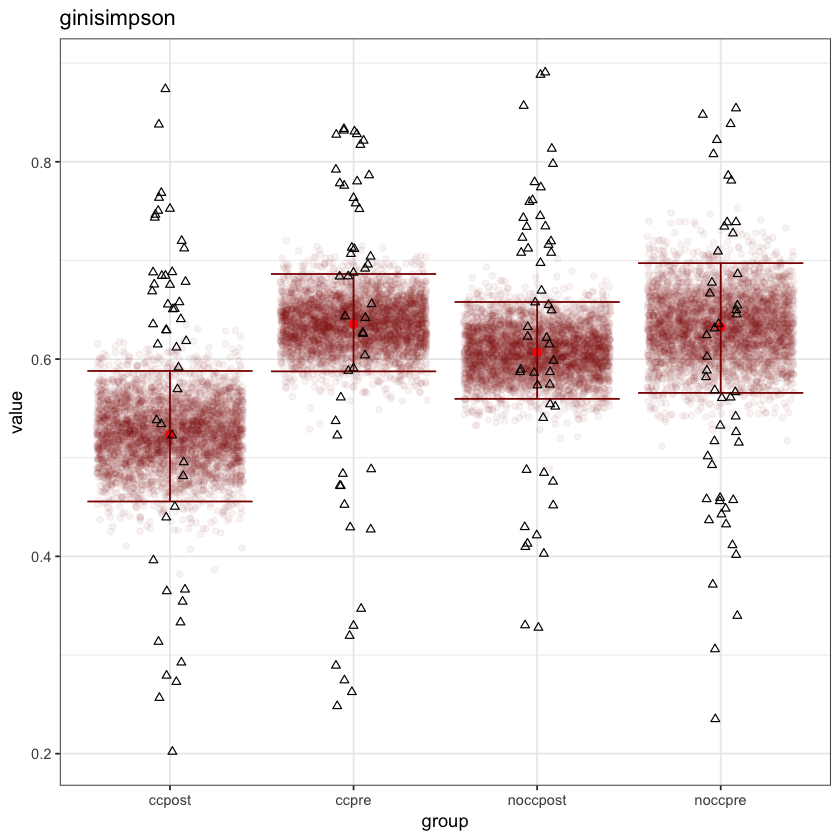

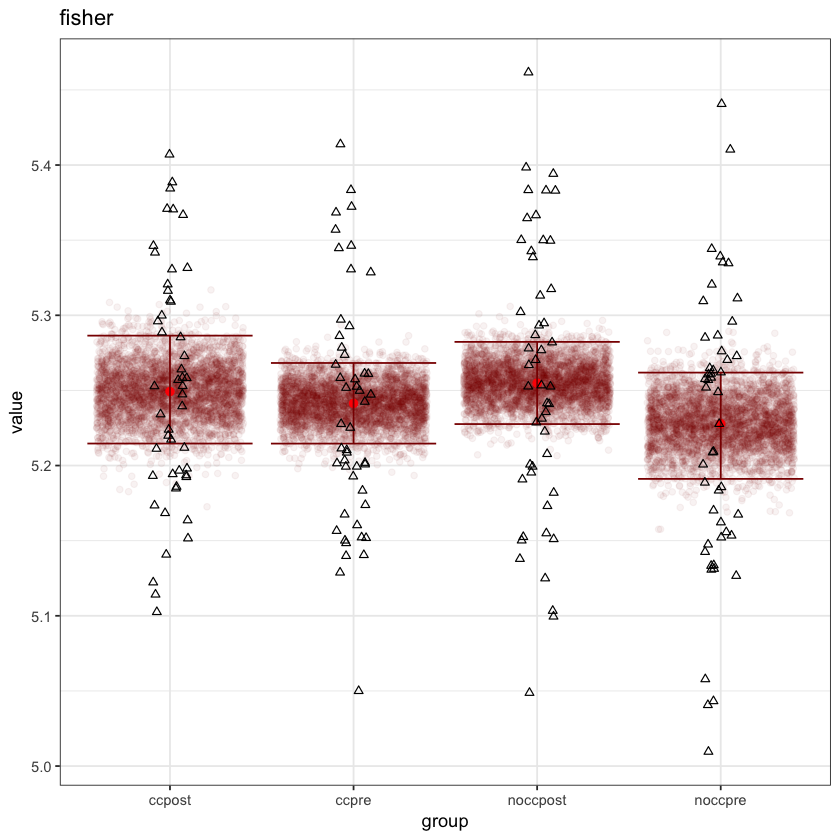

In [40]:
# visualize difference
meta <- meta %>% mutate(
    group = ifelse(groups == "noCCpost", "noccpost", ifelse(groups == "CCpost", "ccpost", ifelse(groups == "CCpre", "ccpre", "noccpre")))
)
lapply(1:length(diversity_index), function(x) {
    p <- plot_effects(div_models_mi[[x]], diversity_index[x]) +
            geom_jitter(data = meta, aes_string("group", diversity_index[x]), width = 0.1, shape = 2)
    ggsave(here(glue("fig/parameter_plot_{x}.png")))
    p
    })

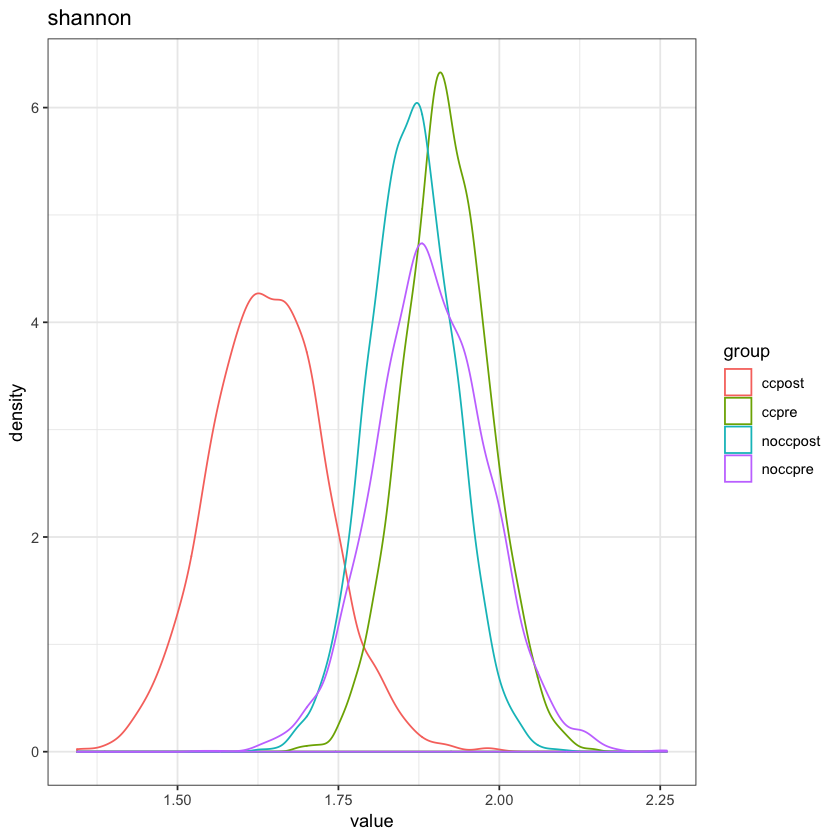

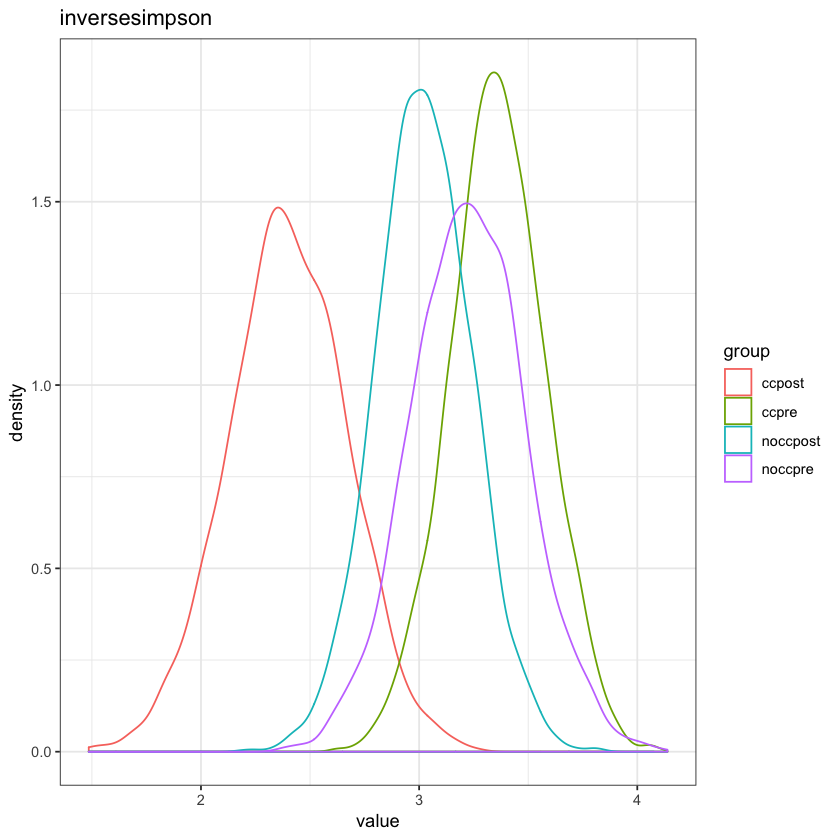

[[1]]

[[2]]

[[3]]

[[4]]


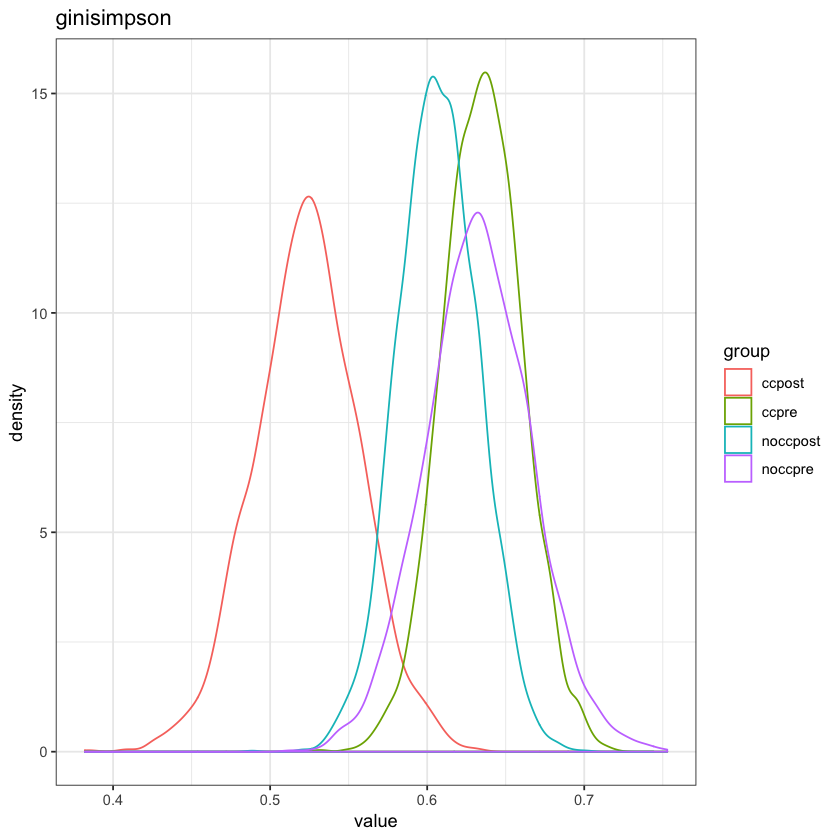

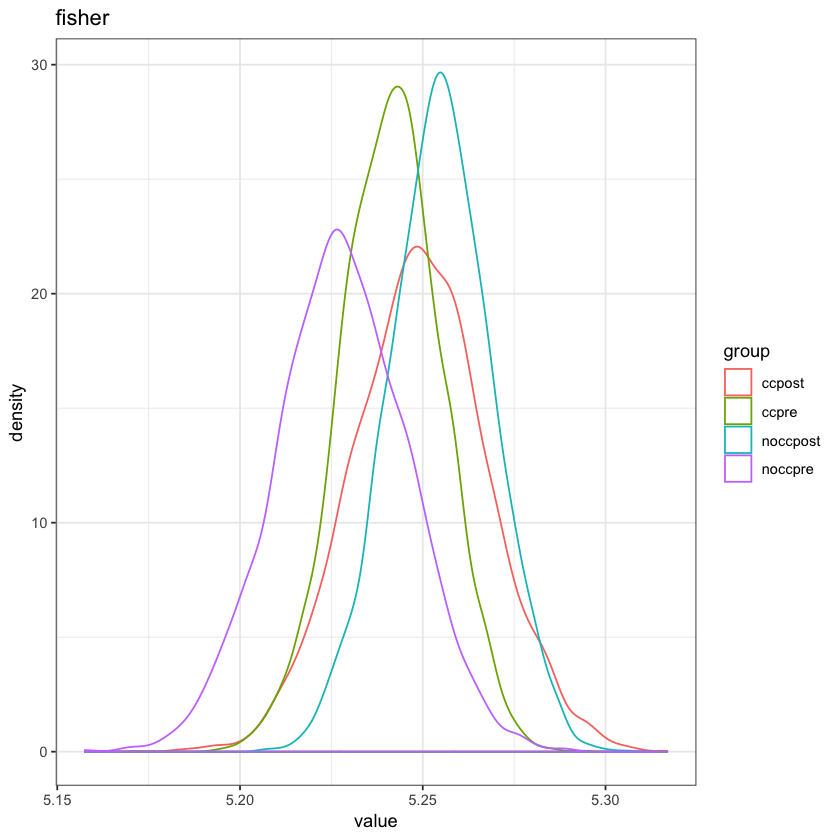

In [41]:
lapply(1:length(diversity_index), function(x) {
    var_name <- diversity_index[x]
    var_name <- gsub("_", "", var_name)
    var_name <- gsub("\\.", "", var_name)
    df <- calc_treatment_effect(div_models_mi[[x]], var_name, summarise = F)
    df %>%
        gather(group, value) %>%
        ggplot(aes(value, color = group)) +
        geom_density() +
        ggtitle(var_name) +
        theme_bw()
})



# Differential abundance testing

In [42]:
# specify prior 
prior <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("lkj(2)", class = "cor"))


control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
folder <- here("models/final_analyses/differential_abundance/")

# define fitting function for fixed sigma
brm_sn <- function(genus) {
    # specify formula
    f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
    formula <- bf(f_d)
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_full")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior, file = model_file
        )
    
}
        
        
# define fitting function for fixed sigma
brm_sn_mi <- function(genus) {
        # delete _ for prior
        sub_prior <- gsub("_", "", genus)
        sub_prior <- gsub("\\.", "", sub_prior)
        # specify prior for mi version
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = sub_prior),
            set_prior("exponential(25)", class = "sd", resp = sub_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = sub_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(25)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
        )
    # specify formula
    f1 <- as.formula(glue("{genus} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
    f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {genus} + age_d_s + (1 + time + age_d_s + {genus}|subject_id)"))
    formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_full_mi")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior_n, file = model_file
        )
    
}
     

        
        
# specify prior 
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"), 
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(25)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma"),
            set_prior("lkj(2)", class = "cor"))


control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
# folder 
folder_d <- here("models/cc_vs_nocc")

# define fitting function distributional
brmd_sn <- function(genus) {
    # specify formula
    f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
    formula_d <- bf(f_d, sigma ~ 1 + time*cc + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id))
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_d_full")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula_d,
        chains = 4, warmup = 1000,
        control = control, prior = prior_d, file = model_file
        )
    
}

# define fitting function distributional + mi
brmd_sn_mi <- function(genus) {
    # delete _ for prior
    sub_prior <- gsub("_", "", genus)
    sub_prior <- gsub("\\.", "", sub_prior)
    # specify prior for mi version
    prior_n <- c(
        set_prior("normal(0, 2)", class = "b", resp = sub_prior),
        set_prior("exponential(15)", class = "sd", resp = sub_prior),
        set_prior("normal(0, 10)", class = "Intercept", resp = sub_prior), 
        set_prior("lkj(2)", class = "cor"),     
        set_prior("normal(0, 2)", class = "b", dpar = "sigma", resp = sub_prior),
        set_prior("exponential(25)", class = "sd", dpar = "sigma", resp = sub_prior),
        set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma", resp = sub_prior),
        set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
        set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
        set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
    )
    # specify formula
    f1 <- as.formula("Enterococcus |mi() ~ 1+ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)")
    f1 <- bf(f1, sigma ~ 1 + time*cc + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id))
    f2 <- as.formula("bf_count_s |mi() ~ 1 + cc*time + Enterococcus + age_d_s + (1 + time + age_d_s + Enterococcus|subject_id)")
    formula_d <- bf(f1) + bf(f2) + set_rescor(FALSE) 
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_d_full_mi")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula_d,
        chains = 4, warmup = 1000,
        control = control, prior = prior_n, file = model_file
        )
    
}

# this function I added for the exluded_id (see below)
# define fitting function for fixed sigma
brm_sn_mi_ex <- function(genus) {
        # delete _ for prior
        sub_prior <- gsub("_", "", genus)
        sub_prior <- gsub("\\.", "", sub_prior)
        # specify prior for mi version
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = sub_prior),
            set_prior("exponential(35)", class = "sd", resp = sub_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = sub_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(35)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
        )
    # specify formula
    f1 <- as.formula(glue("{genus} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
    f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {genus} + age_d_s + (1 + time + age_d_s + {genus}|subject_id)"))
    formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_full_mi")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior_n, file = model_file
        )
    
}

In [43]:
# can only always check a subset of models due to low memory
#models_sn <- lapply(genus, brm_sn_mi)

In [44]:
# remove models that did not fulfil diagnostic criteria
# lapply(genus[exclude_id], function(x) {
#     folder <- here("models/final_analyses/differential_abundance/skew_normal/")
#     file <- glue("{folder}{x}_full_mi.rds")
#     file.remove(file)
# })

In [45]:
# model screening/excluding skew_normal
exclude_id <- c()
for (i in 1:130) {
    fit <- brm_sn_mi(genus[i])
    sum_fit <- summary(fit)
    params <- rbind(sum_fit$fixed, sum_fit$random$subject_id, sum_fit$spec_pars) %>% as.data.frame()
    # extract n of divergent transitions
    n_divergent <- nuts_params(fit) %>% 
        filter(Parameter == "divergent__") %>% 
        summarise(n = sum(Value))
    # extract n of rhat > 1.1        
    n_high_rhat <- dim(filter(params, Rhat >= 1.1))[1]             
    # check if there are divergent transitions
    if (n_high_rhat > 0) {
        print(glue("{genus[i]} has {n_high_rhat} high Rhat parameter values"))
        exclude_id <- c(exclude_id, i)
    } else if (n_divergent$n > 0){
        print(glue("{genus[i]} has {n_divergent$n} divergent transitions"))
        exclude_id <- c(exclude_id, i)
    }     
}
genus_sel <- genus[-exclude_id]
# now I go back and again fit those models with stronger priors

Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

Actinomycetaceae has 2 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”Warning message:
“There were 21 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

Butyrivibriocrossotusetrel has 5 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

Catenibacteriummitsuokaietrel has 1 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”Warning message:
“There were 43 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

Clostridiumnexileetrel has 10 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

Clostridiumsphenoidesetrel has 2 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”Warning message:
“There were 129 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

OutgroupingclostridiumclusterXIVa has 3 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

Prevotellamelaninogenicaetrel has 2 high Rhat parameter values


Warning message:
“There were 21 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

Ruminococcuslactarisetrel has 21 divergent transitions


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

Subdoligranulumvariableatrel has 2 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”Warning message:
“There were 45 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

UnculturedChroococcales has 2 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”Warning message:
“There were 12 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

Vibrio has 2 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

Wissellaetrel has 3 high Rhat parameter values


In [46]:
exclude_id

[1]   1  31  33  40  43  89  97 108 116 120 126 128

In [47]:
calc_treatment_effect <- function(model, var_name, summarise = TRUE, stat = "mean") {
    df <- posterior_samples(model) %>%
        select(
            glue("b_{var_name}_Intercept"), 
            glue("b_{var_name}_ccyes"), 
            glue("b_{var_name}_timepost"), 
            glue("b_{var_name}_ccyes:timepost"), 
            glue("b_{var_name}_age_d_s"), 
            glue("bsp_{var_name}_mibf_count_s")
        ) %>%
        rename(
            noccpre = glue("b_{var_name}_Intercept"), 
            ccpre = glue("b_{var_name}_ccyes"),
            noccpost = glue("b_{var_name}_timepost"),
            ccpost = glue("b_{var_name}_ccyes:timepost"),
            age = glue("b_{var_name}_age_d_s"),
            bf = glue("bsp_{var_name}_mibf_count_s")
        ) %>%
        mutate(
            ccpost = noccpre + ccpre + noccpost + ccpost,
            noccpost = noccpre + noccpost,
            ccpre = noccpre + ccpre
    )    
    if (summarise) {
        df <- df %>% gather(group, value) %>%
            group_by(group) %>%
            do(data.frame(
                central = ifelse(stat == "median", median(.$value), mean(.$value)),
                lower = hpdi(.$value)[1],
                upper = hpdi(.$value)[2]
            ))
    }
    df
}

plot_effects <- function(model, var_name) {
    var_name <- gsub("_", "", var_name)
    var_name <- gsub("\\.", "", var_name)
    df_sum <- calc_treatment_effect(model, var_name)
    df <- calc_treatment_effect(model, var_name, summarise = F)
    # plot
    df %>% gather(group, value) %>%
        ggplot(aes(x = group, value)) +
            geom_jitter(alpha = 0.05, color = "darkred") +
            geom_point(data = df_sum, aes(x = group, y = central), size = 2, color = "red") +
            geom_errorbar(data = df_sum, aes(x = group, y = central,  ymin = lower, ymax = upper), color = "darkred") +
            ggtitle(var_name) +
            theme_bw()
}



In [48]:
age <- tibble(genus = NA, mean = NA, lower = NA, upper = NA, prob = NA, effect = NA)
bf <- tibble(genus = NA, mean = NA, lower = NA, upper = NA, prob = NA, effect = NA)
ccpost_ccpre <- tibble(genus = NA, mean = NA, lower = NA, upper = NA, prob = NA, effect = NA)
ccpost_noccpre <- tibble(genus = NA, mean = NA, lower = NA, upper = NA, prob = NA, effect = NA)
ccpost_noccpost <- tibble(genus = NA, mean = NA, lower = NA, upper = NA, prob = NA, effect = NA)
noccpre_ccpre <- tibble(genus = NA, mean = NA, lower = NA, upper = NA, prob = NA, effect = NA)
noccpost_noccpre <- tibble(genus = NA, mean = NA, lower = NA, upper = NA, prob = NA, effect = NA)
noccpost_ccpre <- tibble(genus = NA, mean = NA, lower = NA, upper = NA, prob = NA, effect = NA)
for (var_name in genus_sel) {
    fit <- brm_sn_mi(var_name)
    df <- calc_treatment_effect(fit, var_name, summarise = F)
    df <- df %>% 
        mutate(            
            ccpost_ccpre = ccpost - ccpre,
            ccpost_noccpre = ccpost - noccpre,
            ccpost_noccpost = ccpost - noccpost,
            noccpre_ccpre = noccpre - ccpre,
            noccpost_noccpre = noccpost - noccpre,
            noccpost_ccpre = noccpost - ccpre) %>%
        select(ccpost_ccpre, ccpost_noccpre, ccpost_noccpost, noccpre_ccpre, noccpost_noccpre, noccpost_ccpre, age, bf) %>%
        gather(effect, value) %>%
        group_by(effect) %>%
        do(data.frame(
            mean = mean(.$value),
            lower = hpdi(.$value)[1],
            upper = hpdi(.$value)[2],
            prob = mean(.$value < 0)
        ))
    age <- rbind(age, tibble(genus = var_name, mean = df$mean[1], lower = df$lower[1], upper = df$upper[1], prob = df$prob[1], effect = "age"))
    bf <- rbind(bf, tibble(genus = var_name, mean = df$mean[2], lower = df$lower[2], upper = df$upper[2], prob = df$prob[2], effect = "bf"))
    ccpost_ccpre <- rbind(ccpost_ccpre, tibble(genus = var_name, mean = df$mean[3], lower = df$lower[3], upper = df$upper[3], prob = df$prob[3], effect = "ccpost_ccpre"))
    ccpost_noccpre <- rbind(ccpost_noccpre, tibble(genus = var_name, mean = df$mean[4], lower = df$lower[4], upper = df$upper[4], prob = df$prob[4], effect = "ccpost_noccpre"))
    ccpost_noccpost <- rbind(ccpost_noccpost, tibble(genus = var_name, mean = df$mean[5], lower = df$lower[5], upper = df$upper[5], prob = df$prob[5], effect = "ccpost_noccpost"))
    noccpre_ccpre <- rbind(noccpre_ccpre, tibble(genus = var_name, mean = df$mean[6], lower = df$lower[6], upper = df$upper[6], prob = df$prob[6], effect = "noccpre_ccpre"))
    noccpost_noccpre <- rbind(noccpost_noccpre, tibble(genus = var_name, mean = df$mean[7], lower = df$lower[7], upper = df$upper[7], prob = df$prob[7], effect = "noccpost_noccpre"))
    noccpost_ccpre <- rbind(noccpost_ccpre, tibble(genus = var_name, mean = df$mean[8], lower = df$lower[8], upper = df$upper[8], prob = df$prob[8], effect = "noccpost_ccpre"))
}

age <- na.omit(age)
bf <- na.omit(bf)
ccpost_ccpre <- na.omit(ccpost_ccpre)
ccpost_noccpre <- na.omit(ccpost_noccpre)
ccpost_noccpost <- na.omit(ccpost_noccpost)
noccpre_ccpre <- na.omit(noccpre_ccpre)
noccpost_noccpre <- na.omit(noccpost_noccpre)
noccpost_ccpre <- na.omit(noccpost_ccpre)

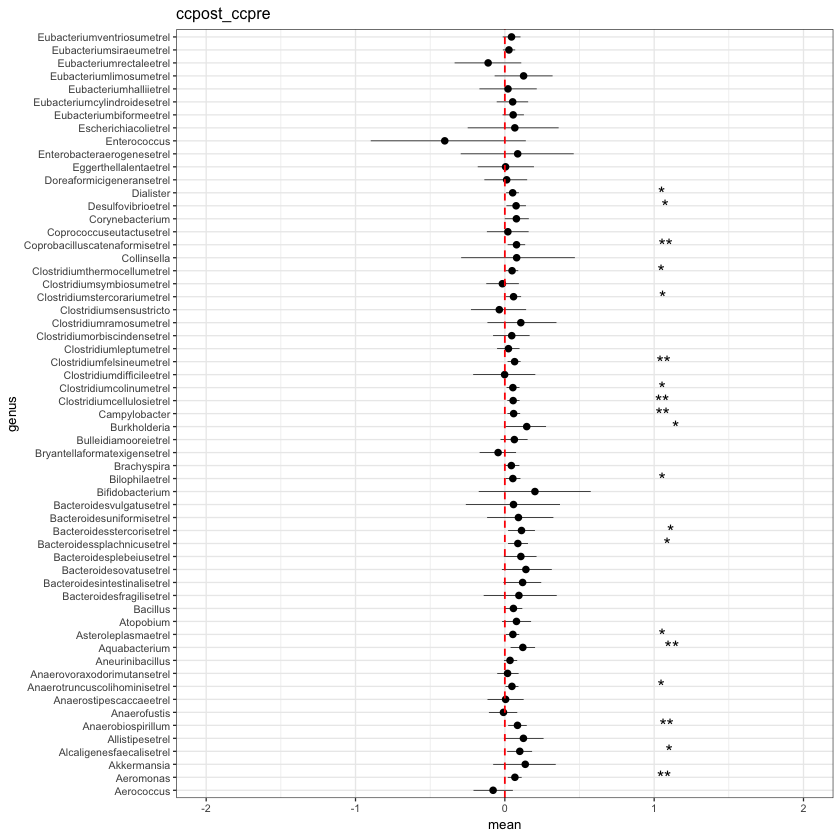

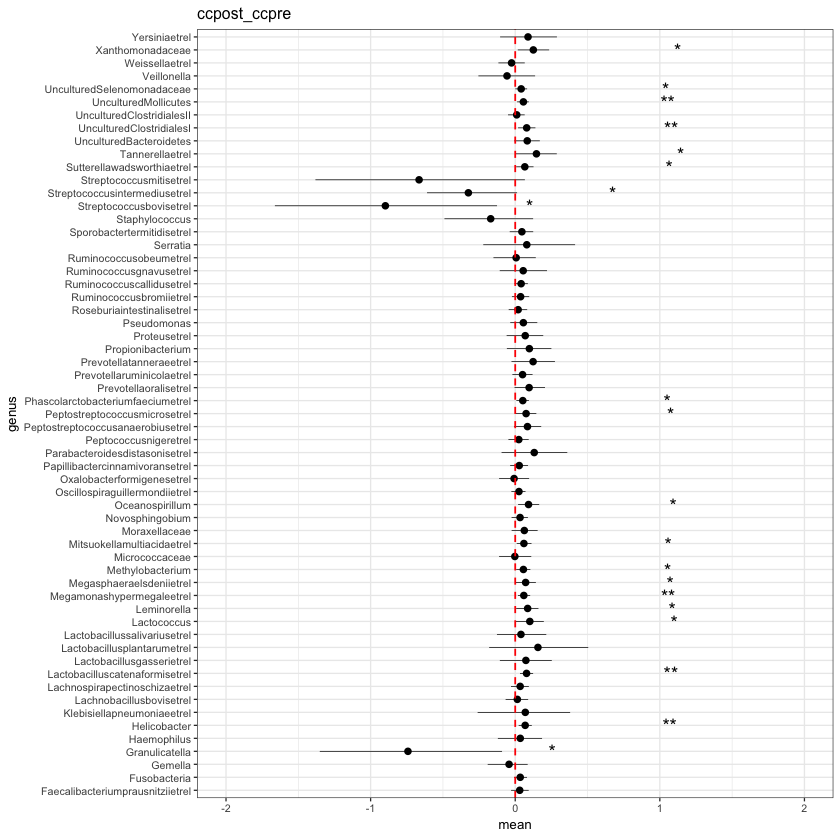

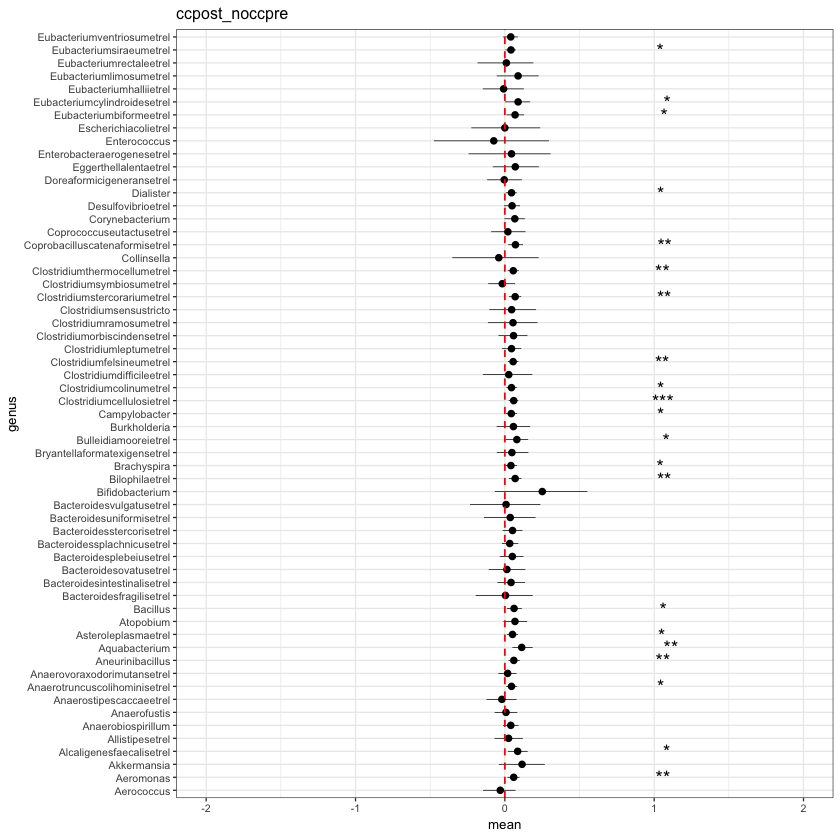

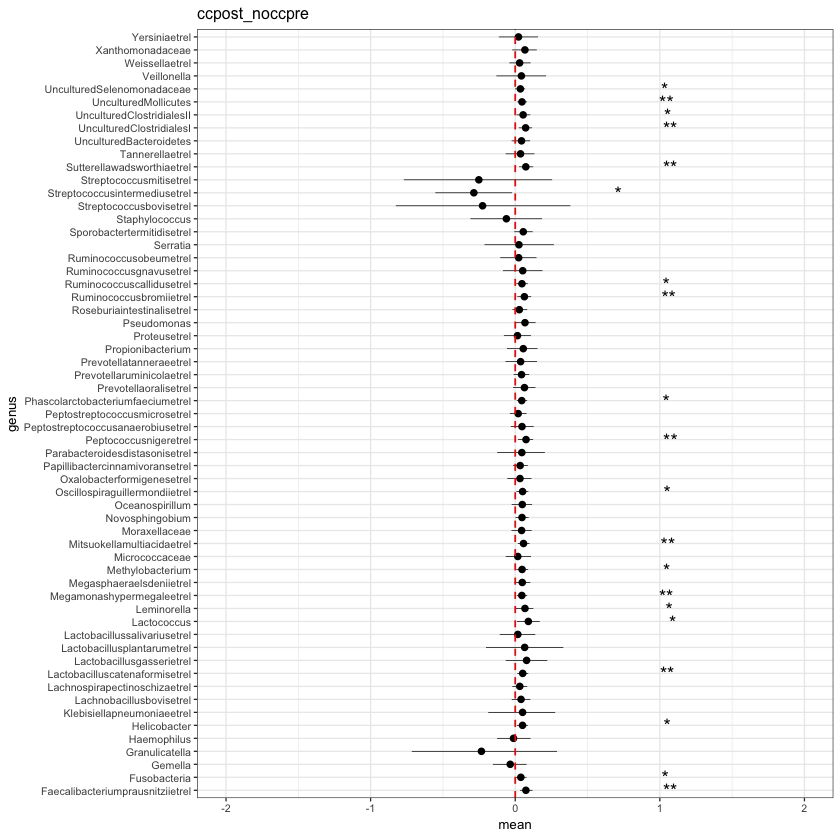

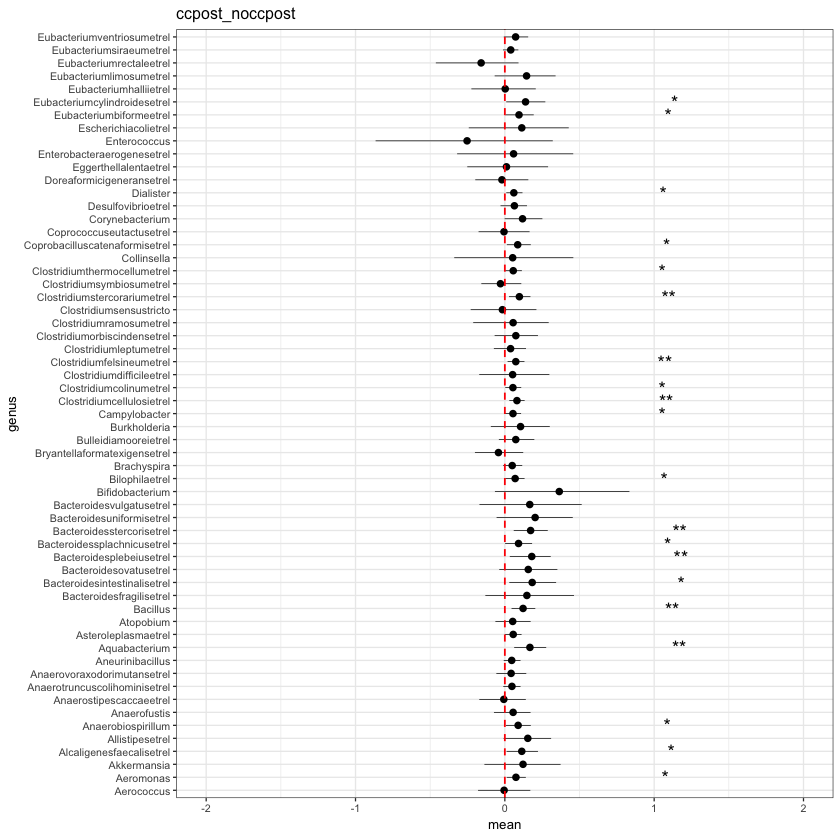

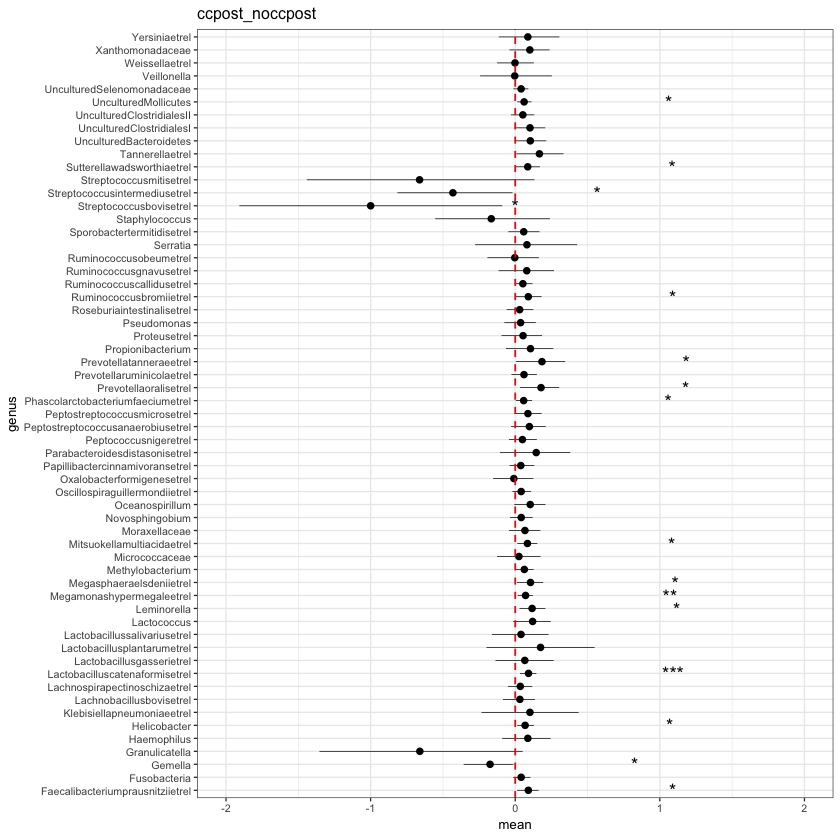

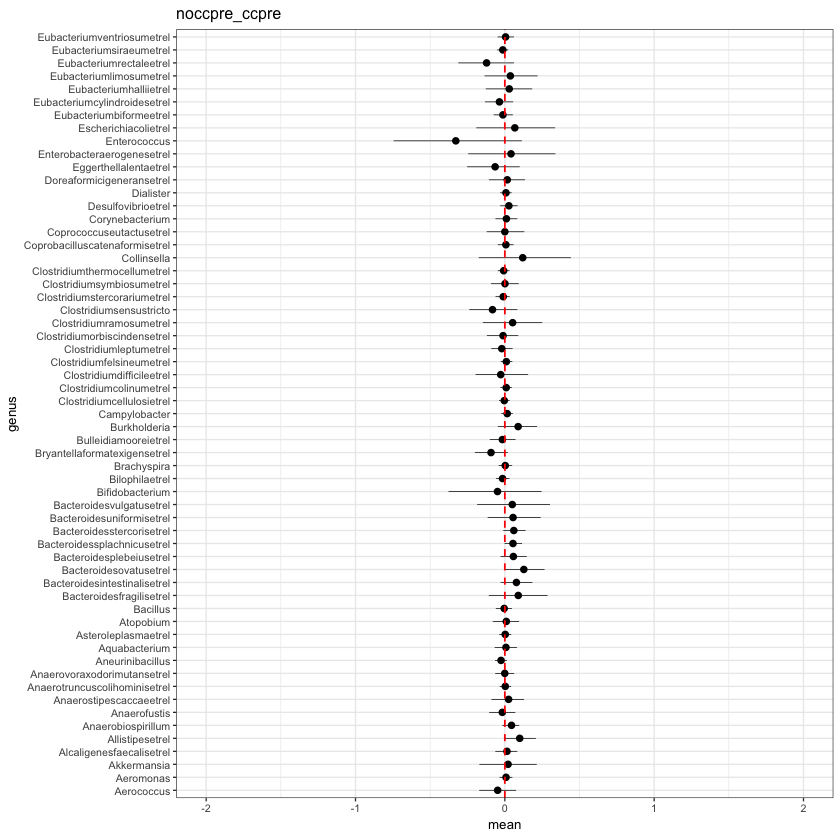

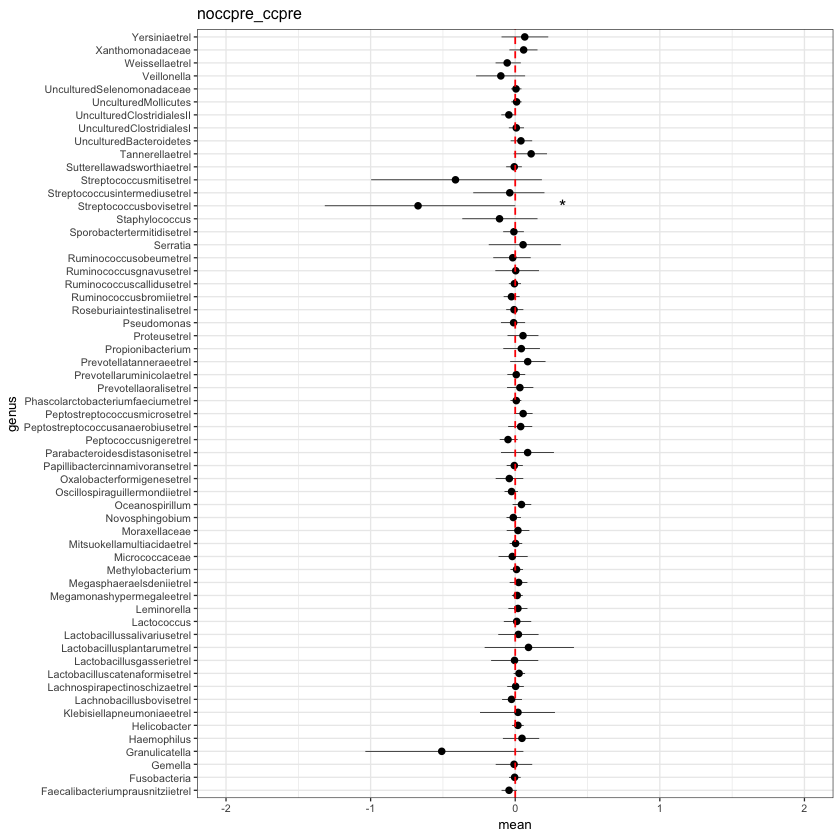

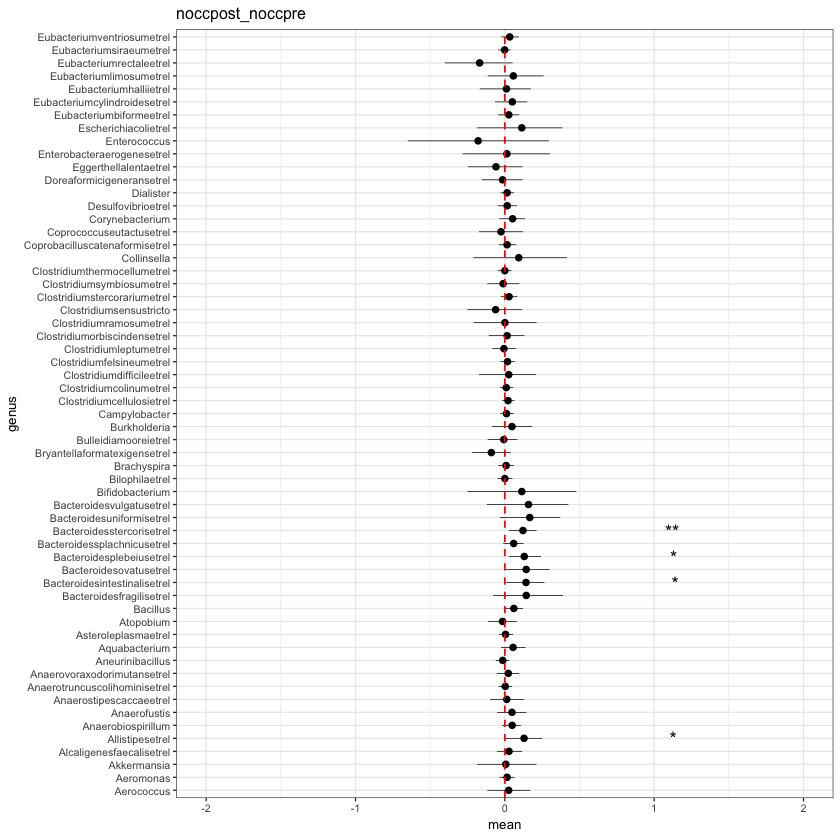

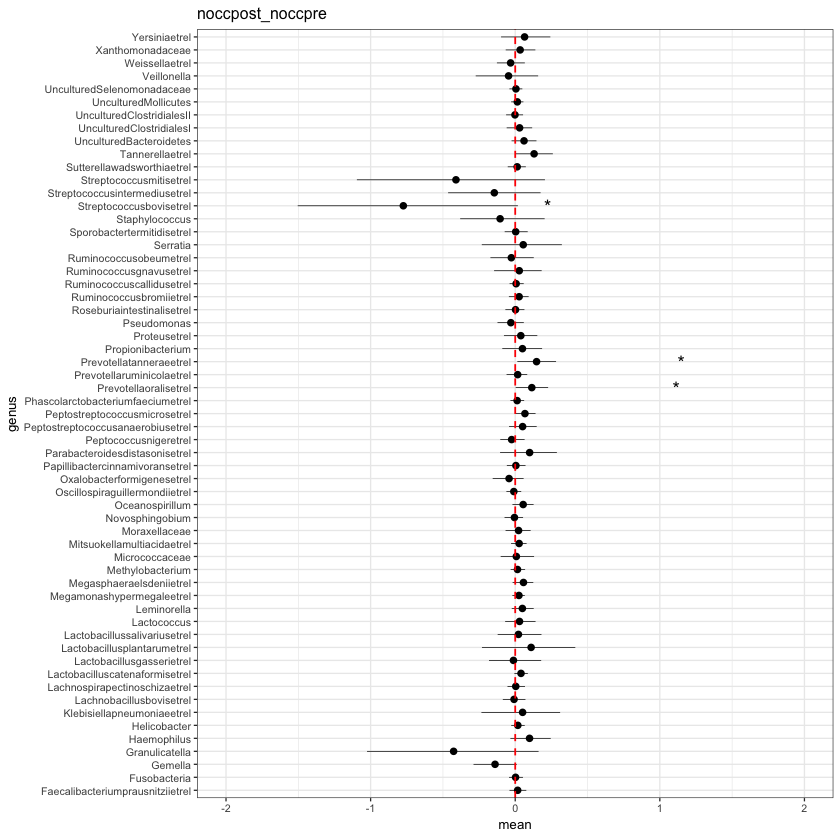

[[1]]
[[1]][[1]]

[[1]][[2]]


[[2]]
[[2]][[1]]

[[2]][[2]]


[[3]]
[[3]][[1]]

[[3]][[2]]


[[4]]
[[4]][[1]]

[[4]][[2]]


[[5]]
[[5]][[1]]

[[5]][[2]]


[[6]]
[[6]][[1]]

[[6]][[2]]



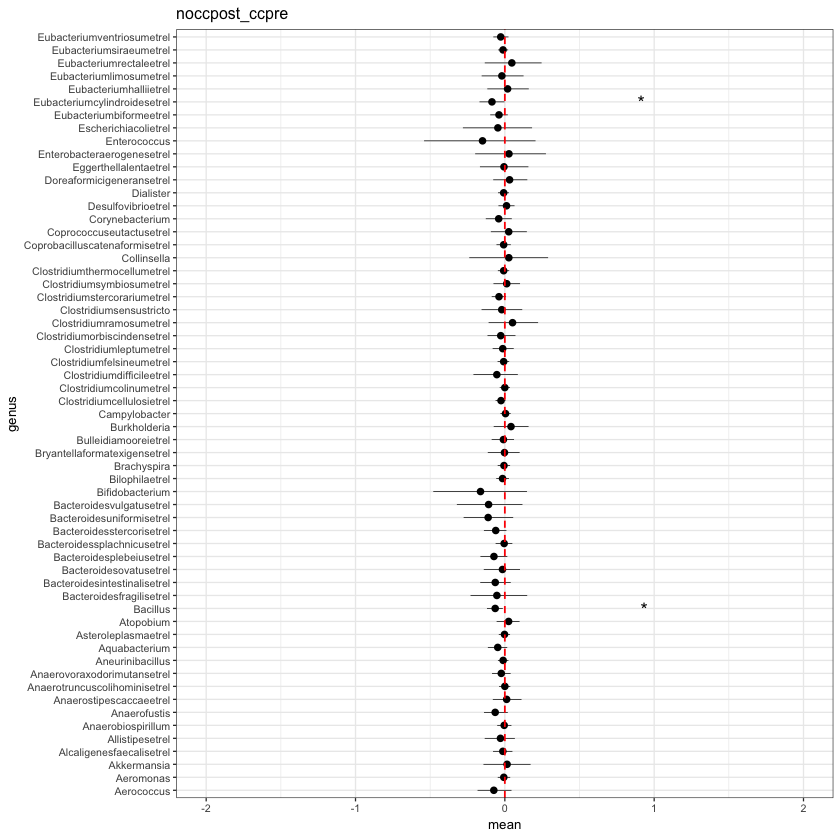

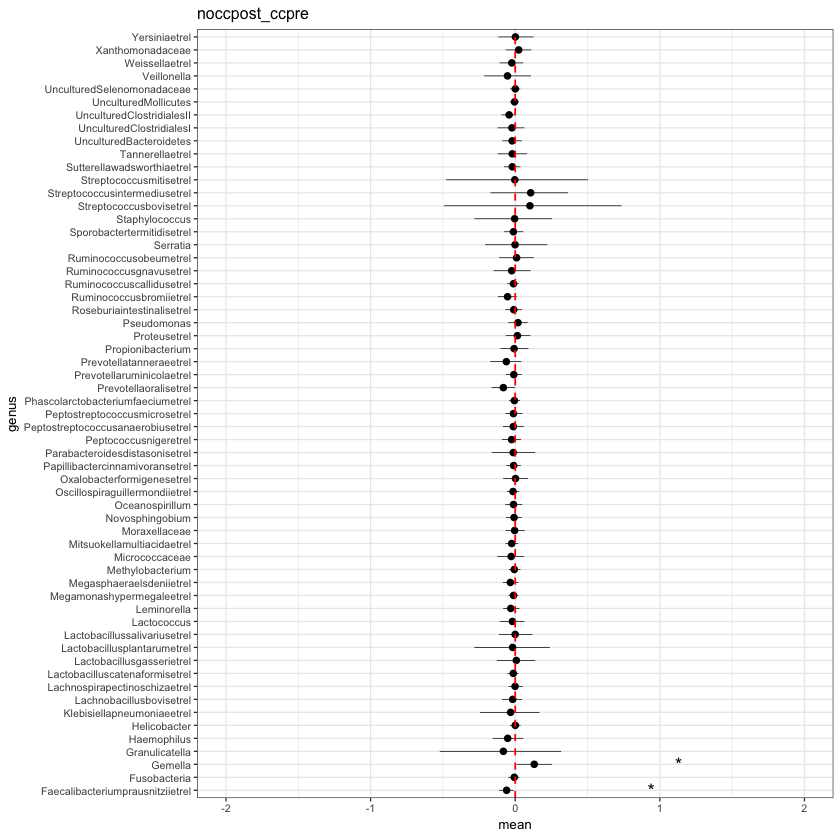

In [49]:
# how are effects distributed
dfs <- list(
    age = age, 
    bf = bf, 
    ccpost_ccpre = ccpost_ccpre, 
    ccpost_noccpre = ccpost_noccpre, 
    ccpost_noccpost = ccpost_noccpost,
    noccpre_ccpre = noccpre_ccpre,
    noccpost_noccpre = noccpost_noccpre,
    noccpost_ccpre = noccpost_ccpre
)
effects_vector <- c(
    "ccpost_ccpre", 
    "ccpost_noccpre",
    "ccpost_noccpost",
    "noccpre_ccpre",   
    "noccpost_noccpre",
    "noccpost_ccpre"
    )

lapply(effects_vector, function(x){
    df <- dfs[[x]] %>% mutate(prob = report_star_nondirectional(prob))
    df1 <- filter(df, genus %in% genus_sel[1:length(genus_sel)/2])
    df2 <- filter(df, genus %in% genus_sel[length(genus_sel)/2+1:length(genus_sel)])
    p1 <- ggplot(df1, aes(genus, mean, label = prob)) +
        geom_pointrange(aes(ymin = lower, ymax = upper), size = 0.2) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_text(nudge_y = 1) +
        ggtitle(x) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
        ylim(-2, 2) +
        coord_flip() +
        theme_bw(base_size = 8)
    
    p2 <- ggplot(df2, aes(genus, mean, label = prob)) +
        geom_pointrange(aes(ymin = lower, ymax = upper), size = 0.2) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_text(nudge_y = 1) +
        ggtitle(x) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
        ylim(-2, 2) +
        coord_flip() +
        theme_bw(base_size = 8)
    list(p1, p2)
})


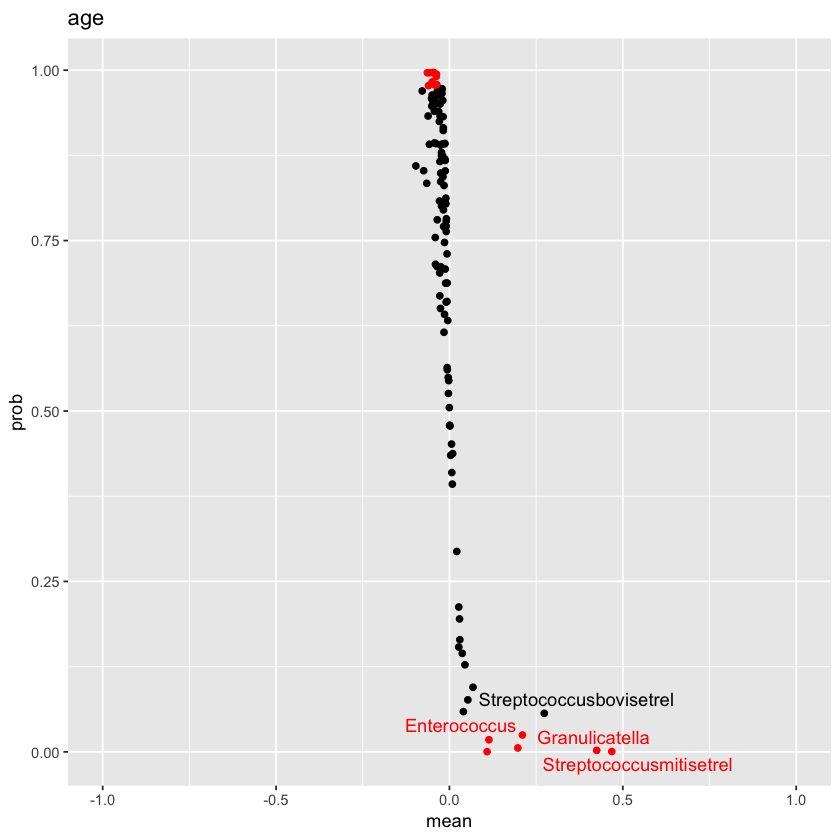

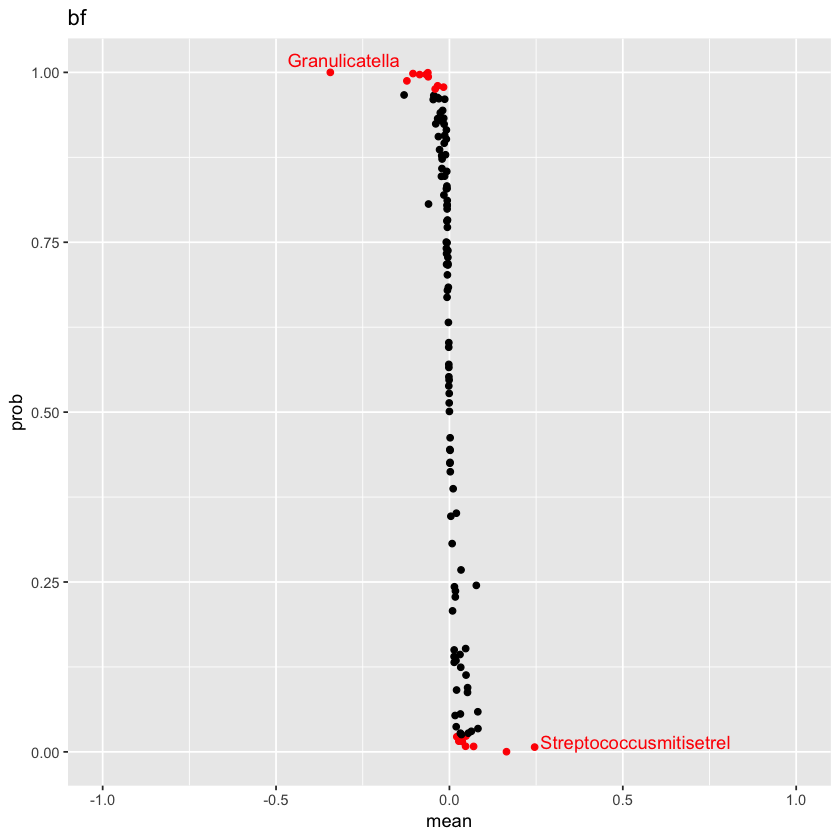

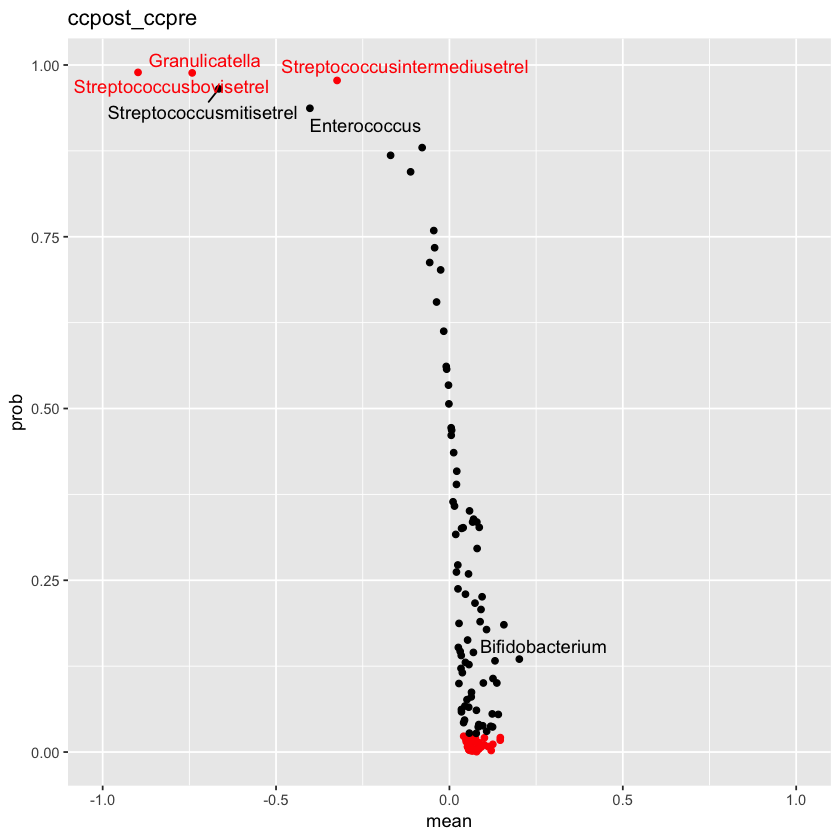

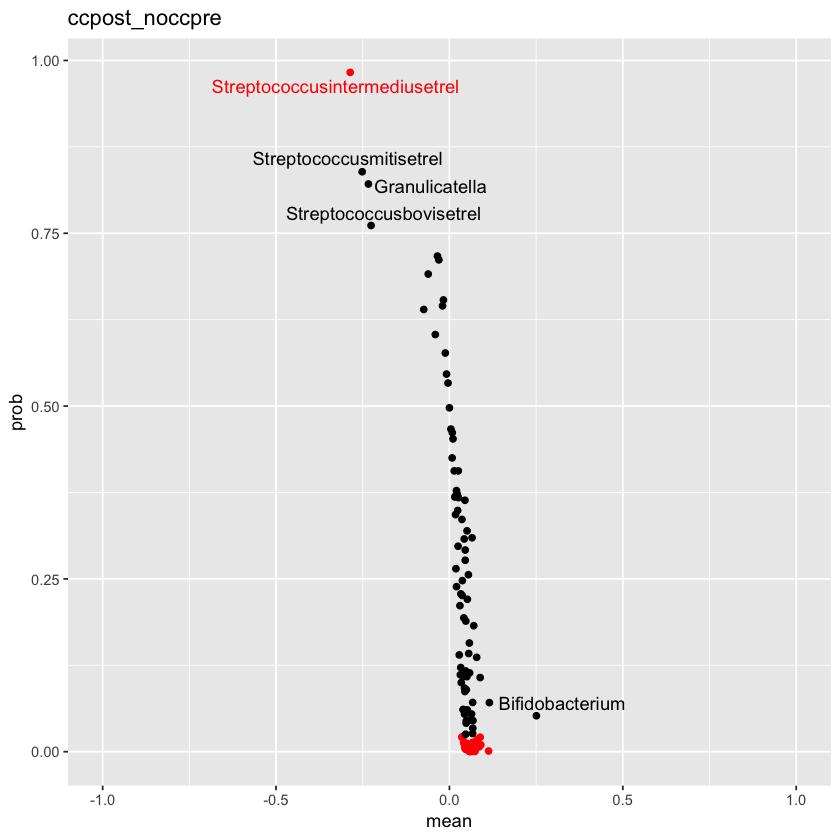

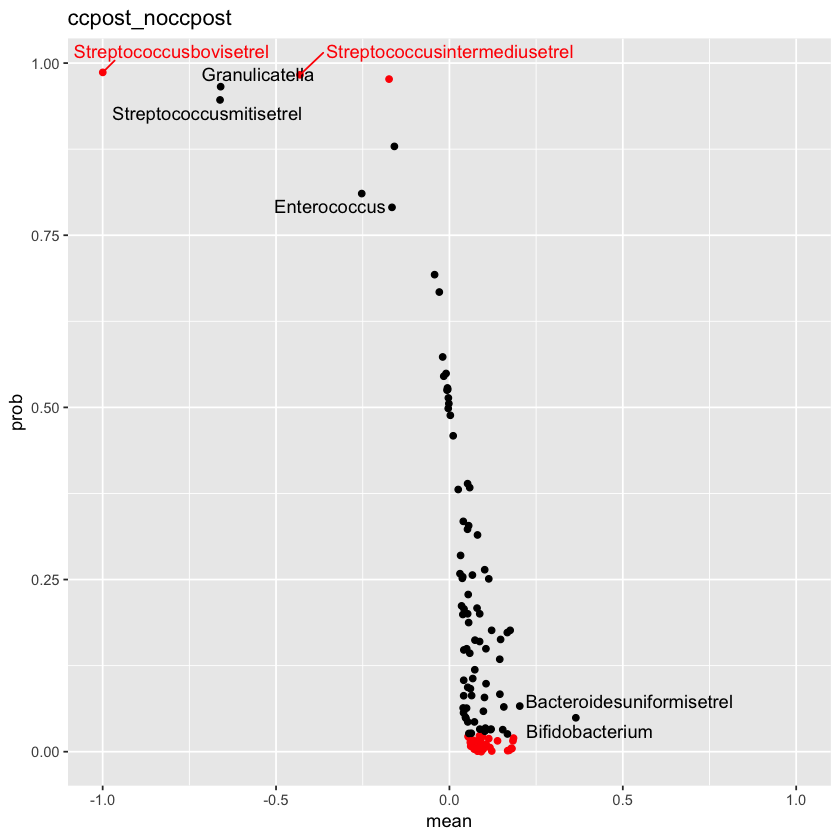

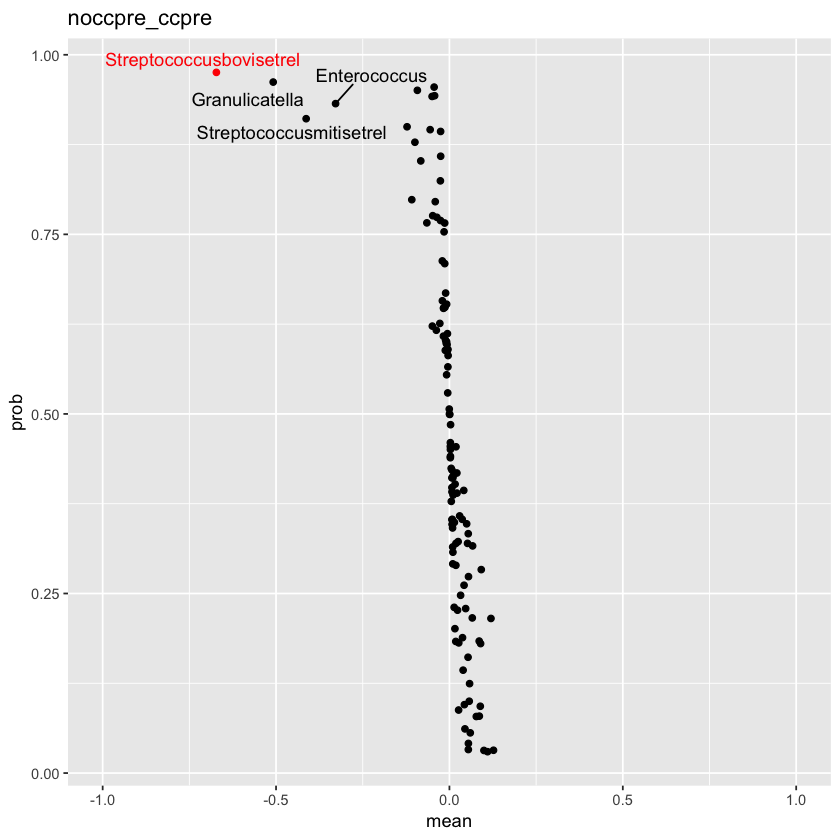

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]


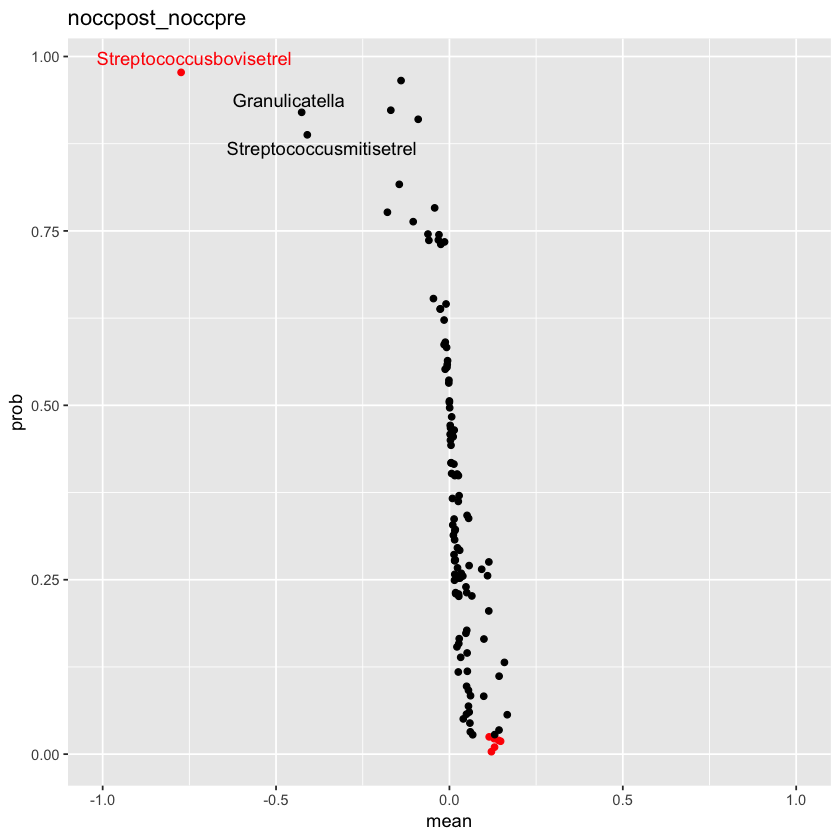

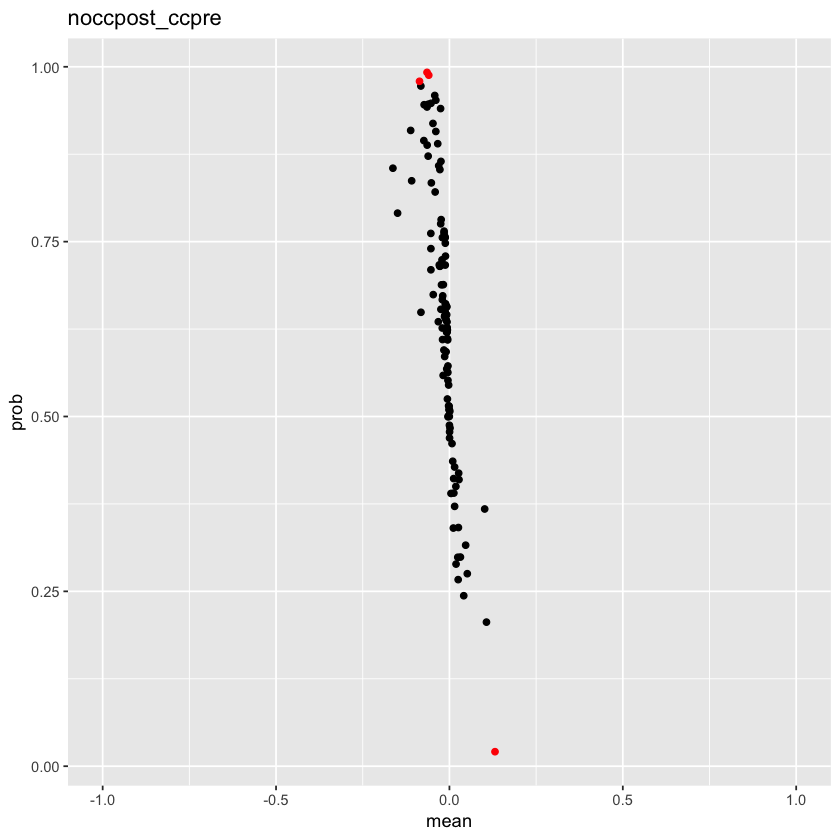

In [50]:
library(qvalue)
age <- age %>% 
    arrange(prob) %>%
    mutate(qvalue = cummean(prob))
bf <- bf %>% 
    arrange(prob) %>%
    mutate(qvalue = cummean(prob))
ccpost_ccpre <- ccpost_ccpre %>% 
    arrange(prob) %>%
    mutate(qvalue = cummean(prob))
ccpost_noccpre <- ccpost_noccpre %>% 
    arrange(prob) %>%
    mutate(qvalue = cummean(prob))
ccpost_noccpost <- ccpost_noccpost %>% 
    arrange(prob) %>%
    mutate(qvalue = cummean(prob))
noccpre_ccpre <- noccpre_ccpre %>% 
    arrange(prob) %>%
    mutate(qvalue = cummean(prob))
noccpost_noccpre <- noccpost_noccpre %>% 
    arrange(prob) %>%
    mutate(qvalue = cummean(prob))
noccpost_ccpre <- noccpost_ccpre %>% 
    arrange(prob) %>%
    mutate(qvalue = cummean(prob))


effects <- rbind(age, bf, ccpost_ccpre, ccpost_noccpre, ccpost_noccpost, noccpre_ccpre, noccpost_noccpre, noccpost_ccpre)

library(ggrepel)
lapply(effects$effect %>% unique(), function(x){
    effects %>% filter(effect == x) %>%
    ggplot(aes(mean, prob, color = ifelse(prob <= 0.025 | prob >= 0.975, "sig", "notsig"), label = ifelse(abs(mean)>= 0.2, genus, ""))) +
            geom_point() + 
            xlim(-1, 1) +
            ggtitle(x) +
            scale_colour_manual(values = c("sig" = "red", "notsig" = "black")) +
            geom_text_repel() +
            theme(legend.position="none")
})


In [51]:
effects %>% 
    filter(prob < 0.025 | prob > 0.975) %>%
    group_by(effect) %>%
    summarise(n = n())

effect           n 
1 age              16
2 bf               20
3 ccpost_ccpre     39
4 ccpost_noccpost  36
5 ccpost_noccpre   41
6 noccpost_ccpre    4
7 noccpost_noccpre  7
8 noccpre_ccpre     1

In [52]:
data %>% group_by(groups) %>% summarise(mean = median(Streptococcusmitisetrel))

groups   mean    
1 CCpost   3.923501
2 CCpre    4.376024
3 noCCpost 3.951848
4 noCCpre  3.752681

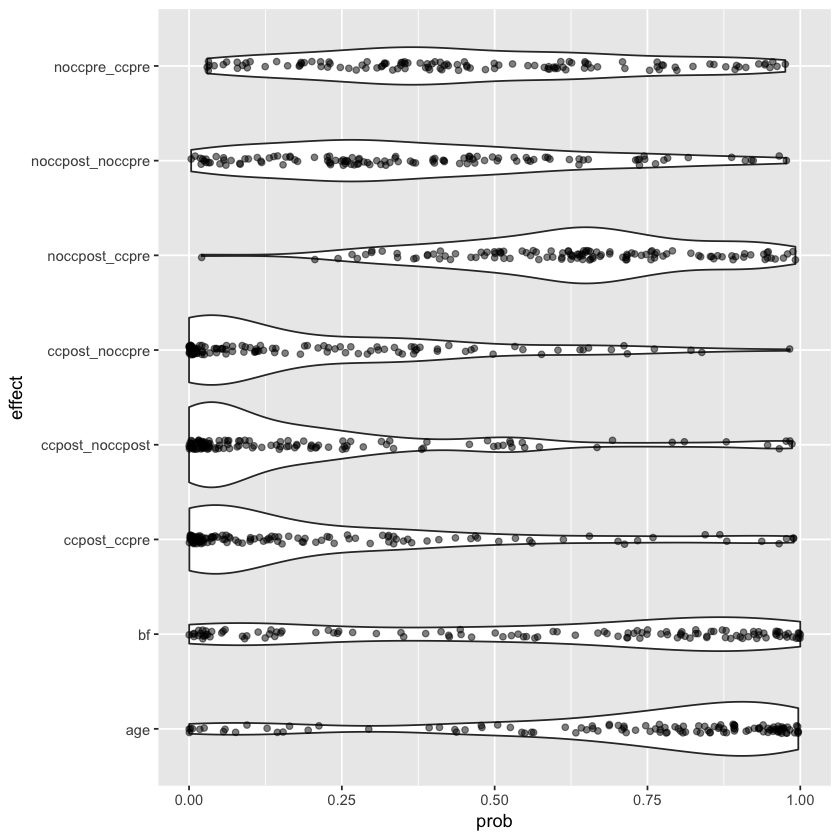

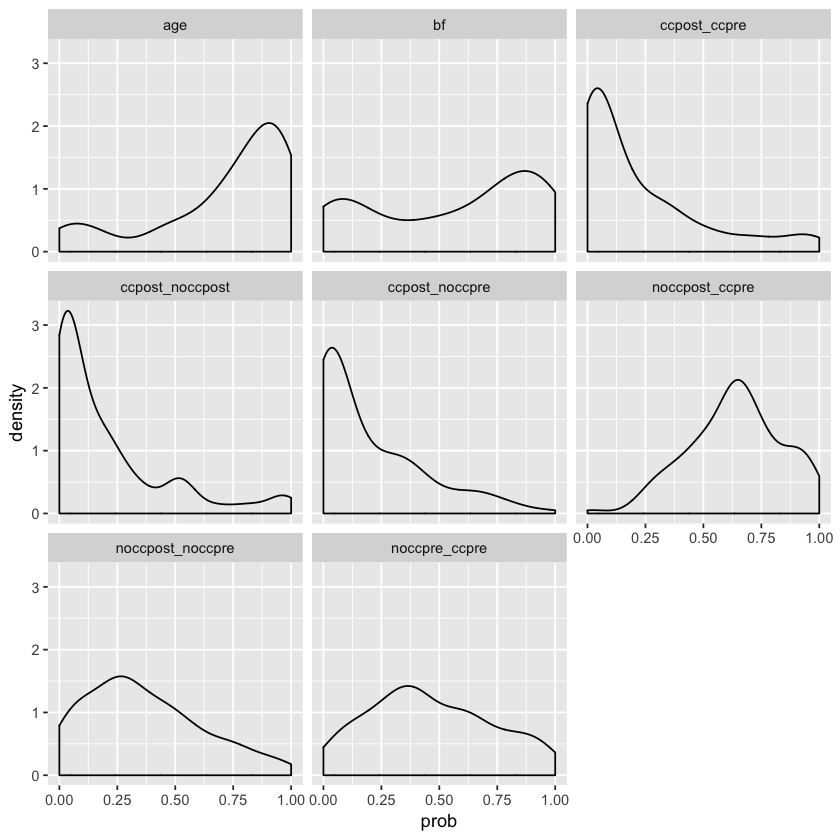

In [53]:
# how are the probabilities distributes? In my understanding, if there is no difference between ccpost
# and the other groups, thus the parameter mu is the same, then the probability that group difference is <0 should be close to 50%. 
# If the parameters where not similar but in a non-systematic way, then p should be uniformly distributed ?!
# But if there is a systematic difference I would expect p mostly either < 0.05 or >0.95
effects %>%
    ggplot(aes(effect, prob)) +
    geom_violin() +
    geom_jitter(alpha = 0.5, width = 0.05) +
    coord_flip()

effects %>% 
    ggplot(aes(prob)) +
    geom_density() +
    facet_wrap(~effect)

## Non-parametric group comparison

In [54]:
ccpre <- sapply(genus, function(x) {
    df <- data %>% 
        select(groups, x) %>% 
        filter(groups %in% c("CCpost", "CCpre")) %>%
        droplevels()
    
    colnames(df) <- c("groups", "genus")
    list(x =  wilcox.test(genus ~ groups, paired = TRUE, data = df)$p.value)
})

noccpre <- sapply(genus, function(x) {
    df <- data %>% 
        select(groups, x) %>% 
        filter(groups %in% c("CCpost", "noCCpre")) %>%
        droplevels()
    
    colnames(df) <- c("groups", "genus")
    list(x =  wilcox.test(genus ~ groups, paired = FALSE, data = df)$p.value)
})

noccpost <- sapply(genus, function(x) {
    df <- data %>% 
        select(groups, x) %>% 
        filter(groups %in% c("CCpost", "noCCpost")) %>%
        droplevels()
    
    colnames(df) <- c("groups", "genus")
    list(x =  wilcox.test(genus ~ groups, paired = FALSE, data = df)$p.value)
})


In [55]:
ccpre <- ccpre %>% as.tibble() %>% add_column(effect = "ccpre") %>% gather(genus, pvalue, -effect)
noccpre <- noccpre %>% as.tibble() %>% add_column(effect = "noccpre") %>% gather(genus, pvalue, -effect)
noccpost <- noccpost %>% as.tibble() %>% add_column(effect = "noccpost") %>% gather(genus, pvalue, -effect)

In [56]:
# qvalues
ccpre$q <- qvalue(ccpre$pvalue)$qvalues
noccpre$q <- qvalue(noccpre$pvalue, lambda = 0)$qvalues
noccpost$q <- qvalue(noccpost$pvalue)$qvalues
wilcox_result <- rbind(ccpre, noccpre, noccpost)

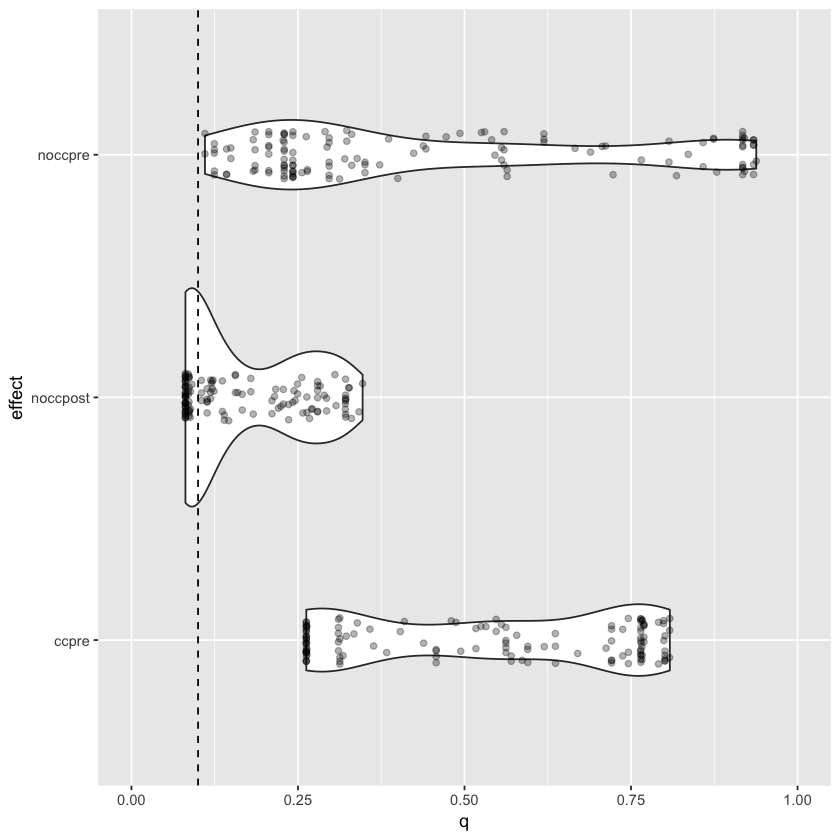

In [57]:
# distribution of p values:
wilcox_result %>%
    ggplot(aes(effect, q)) +
    geom_violin() +
    geom_jitter(width = 0.1, alpha = 0.3) +
    ylim(0, 1) +
    geom_hline(yintercept = 0.1, linetype = "dashed") +
    coord_flip()

[1] 0.04448411 0.04448411 0.04448411 0.04448411 0.04448411 0.04448411
 [7] 0.04448411 0.04448411 0.04448411 0.04448411 0.04448411 0.04448411
[13] 0.04448411 0.04448411 0.04448411 0.04826218

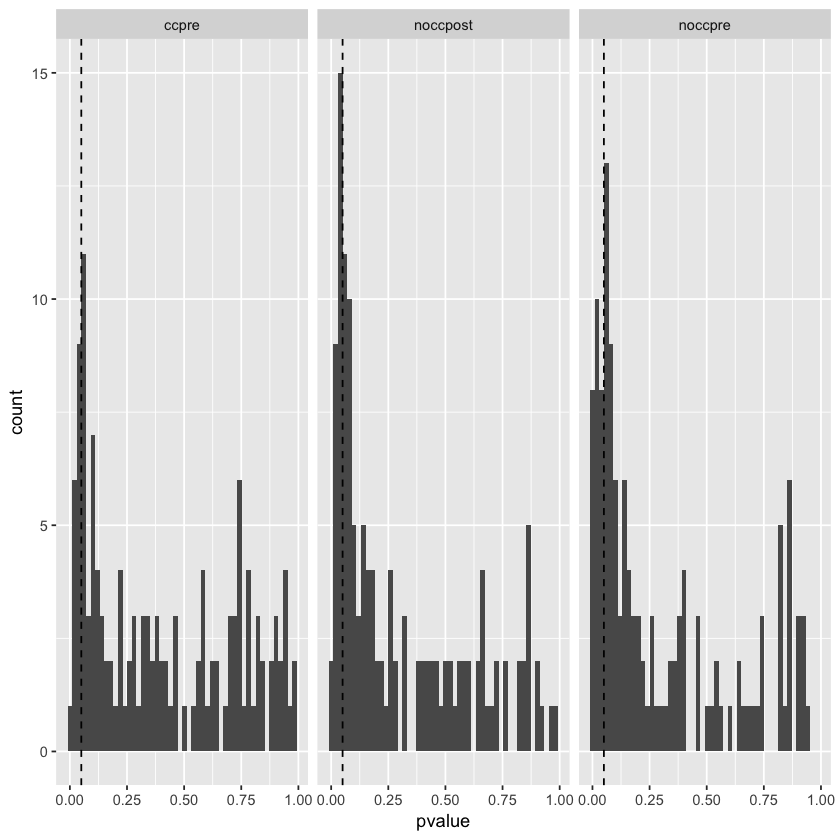

In [58]:
test <- 
    wilcox_result %>% 
        filter(pvalue <= 0.05, effect=="ccpre")  %>%
        arrange(pvalue)
qvalue(test$pvalue, lambda = 0)$qvalue

wilcox_result %>% 
    ggplot(aes(pvalue)) +
    geom_histogram(bins = 50) +
    geom_vline(xintercept = 0.05, linetype = "dashed") +
    facet_wrap(~effect)

In [59]:
kruskal <- sapply(genus, function(x) {
    df <- data %>% 
        select(groups, x)
    
    colnames(df) <- c("groups", "genus")
    list(x =  kruskal.test(genus~groups, data = df)$p.value)
})


In [60]:
kruskal <- kruskal %>% as.tibble() %>% gather(genus, pvalue) %>% arrange(pvalue)

In [61]:
kruskal$q <- qvalue(kruskal$pvalue, lambda = 0)$qvalues

## Frequentist hierarchical modeling

In [159]:
library(lme4)
library(car)
library(mice)
# i change contrasts to ease comparison, which is a bit different
# in frequentist setting
data_imp <-  data %>%
    select(-everything(), subject_id, age_d_s, time, cc, bf_count_s, Enterococcus, Staphylococcus, Bifidobacterium) %>%
    mice(m = 5, print = F)
# use example imputed data
data.f <- data
contrasts(data.f$cc)[1, 1] <- 1
contrasts(data.f$cc)[2, 1] <- 0
contrasts(data.f$time)[1, 1] <- 1
contrasts(data.f$time)[2, 1] <- 0

In [ ]:
results <- list()
results_div <- list()
for (i in 1:5) {
    data.f[c(rownames(data_imp$imp$bf_count_s)), "bf_count_s"] <- data_imp$imp$bf_count_s[, i]
    # lmes for differential abundance testing
    lme_fits <- 
        lapply(genus, function(x) {
            form <- glue("{x} ~ cc*time + age_d_s + bf_count_s + (1|subject_id)")
            l4fit <- lmer(form, data = data.f)
            estimates <- fixef(l4fit)  %>% as.tibble()
            lme_fit <- Anova(l4fit, test = "F", type = 2) %>% 
                        rownames_to_column("effect") %>%
                        add_column(estimate = estimates$value[-1]) %>%
                        add_column(genus = x) %>%
                        select(effect, estimate, F, Df, Df.res, `Pr(>F)`, genus)
            lme_fit
        })
    # lmes for diversity between and within groups
    lme_fits_div <- 
        lapply(diversity_index, function(x) {
            form <- glue("{x} ~ cc*time + age_d_s + bf_count_s + (1|subject_id)")
            l4fit <- lmer(form, data = data.f)
            estimates <- fixef(l4fit)  %>% as.tibble()
            lme_fit <- Anova(l4fit, test = "F", type = 2) %>% 
                        rownames_to_column("effect") %>%
                        add_column(estimate = estimates$value[-1]) %>%
                        add_column(index = x) %>%
                        select(effect, estimate, F, Df, Df.res, `Pr(>F)`, index)
            lme_fit
        })
    # manipulate data to have all in a list of dfs in the end
    # first for abundances
    lme_all <- plyr::ldply(lme_fits, data.frame)
    lme_all_div <- plyr::ldply(lme_fits_div, data.frame)
    lme_cc <- lme_all %>% filter(effect == "cc")
    lme_time <- lme_all %>% filter(effect == "time")
    lme_age <- lme_all %>% filter(effect == "age_d_s")
    lme_bf <- lme_all %>% filter(effect == "bf_count_s")
    lme_cctime <- lme_all %>% filter(effect == "cc:time")
    # for divs
    lme_cc_div <- lme_all_div %>% filter(effect == "cc")
    lme_time_div <- lme_all_div %>% filter(effect == "time")
    lme_age_div <- lme_all_div %>% filter(effect == "age_d_s")
    lme_bf_div <- lme_all_div %>% filter(effect == "bf_count_s")
    lme_cctime_div <- lme_all_div %>% filter(effect == "cc:time")
    # add qvalues
    lme_fits <- lapply(list(lme_cc, lme_time, lme_age, lme_bf, lme_cctime), function(df){
        df$q <- qvalue(df$`Pr..F.`)$qvalues
        df
    })
    lme_fits_div <- lapply(list(lme_cc_div, lme_time_div, lme_age_div, lme_bf_div, lme_cctime_div), function(df){
        df$q <- qvalue(df$`Pr..F.`, lambda = 0)$qvalues
        df
    })
    # add all together
    lme_all <- plyr::ldply(lme_fits, data.frame)
    lme_all_div <- plyr::ldply(lme_fits_div, data.frame)
    
    results[[i]] <- lme_all
    results_div[[i]] <- lme_all_div
}

In [ ]:
results[[1]]

In [122]:
lme_all <- plyr::ldply(lme_fits, data.frame)
lme_all_div <- plyr::ldply(lme_fits_div, data.frame)

In [123]:
lme_cc <- lme_all %>% filter(effect == "cc")
lme_time <- lme_all %>% filter(effect == "time")
lme_age <- lme_all %>% filter(effect == "age_d_s")
lme_bf <- lme_all %>% filter(effect == "bf_count_s")
lme_cctime <- lme_all %>% filter(effect == "cc:time")
# for divs
lme_cc_div <- lme_all_div %>% filter(effect == "cc")
lme_time_div <- lme_all_div %>% filter(effect == "time")
lme_age_div <- lme_all_div %>% filter(effect == "age_d_s")
lme_bf_div <- lme_all_div %>% filter(effect == "bf_count_s")
lme_cctime_div <- lme_all_div %>% filter(effect == "cc:time")

In [124]:
library(qvalue)
lme_fits <- lapply(list(lme_cc, lme_time, lme_age, lme_bf, lme_cctime), function(df){
    df$q <- qvalue(df$`Pr..F.`)$qvalues
    df
})
lme_fits_div <- lapply(list(lme_cc_div, lme_time_div, lme_age_div, lme_bf_div, lme_cctime_div), function(df){
    df$q <- qvalue(df$`Pr..F.`, lambda = 0)$qvalues
    df
})

In [125]:
lme_all <- plyr::ldply(lme_fits, data.frame)
lme_all_div <- plyr::ldply(lme_fits_div, data.frame)

In [115]:
lme_all$effect %>%unique()

[1] "cc"         "time"       "age_d_s"    "bf_count_s" "cc:time"